In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gmsh

In [2]:
import gmsh
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
import matplotlib.image as mpimg
import scipy.sparse as sp
from scipy.sparse.linalg import eigs

In [21]:
g = -9.81

In [3]:
def triangle_jacobian(x1,y1,x2,y2,x3,y3):
    dx_deps = -x1 + x2
    dx_deta = -x1 + x3
    dy_deps = -y1 + y2
    dy_deta = -y1 + y3
    
    jacobian = dx_deps*dy_deta - dx_deta*dy_deps
    return jacobian

In [4]:
def jac_matrix(x1,y1,x2,y2,x3,y3):
    dx_deps = -x1 + x2
    dx_deta = -x1 + x3
    dy_deps = -y1 + y2
    dy_deta = -y1 + y3
    jac = np.array([[dx_deps, dy_deps],[dx_deta, dy_deta]])
    return jac

In [5]:
def properties_tank1(x,y):
    if 0.3 < x < 6.9 and 14.8 < y < 17.7:
        return 2.2e9, 1000, 0.5
    
    elif y > 18:
        return 70e9, 2700, 0.3
    
    else:
        return 30e9, 2400, 0.2

In [224]:
def properties_tank2(x,y):
    if 1 < x < 17 and 42.25 < y < 45.25:
        return 2.2e9, 1000, 0.5
    
    elif y > 47.5:
        return 70e9, 2700, 0.3
    
    else:
        return 30e9, 2400, 0.2

In [225]:
def cal_centroid(x1,y1,x2,y2,x3,y3):
    x_c = (x1 +x2 + x3)/3
    y_c = (y1 +y2+y3)/3
    return x_c, y_c

In [226]:
def von_mises(stress):
    n_ele = stress.shape[1]
    von_m = np.zeros((1,n_ele))
    for i in range(n_ele):
        s_x = stress[0,i]
        s_y = stress[1,i]
        s_xy = stress[2,i]
        val = ((s_x - s_y)**2 + s_x**2 + s_y**2 + 6*s_xy**2)**0.5
        von_m[0,i] = val
    return von_m
    

In [227]:
def cal_eigen(M,K):
    eigenvalues, eigenvectors = eigs(K, M = M, k= K.shape[0] -2, sigma = 0, which = 'LM')
    return eigenvalues, eigenvectors

In [228]:
def fill_b(N_x, N_y):
    b = np.zeros((3,6))
    for i in range(3):
        for j in range(3):
            if j == 0:
                
                b[j,2*i] = N_x[i]
                
            elif j == 1:
                b[j,2*i+1] = N_y[i]
                
            else:
                b[j,2*i] = N_y[i]
                b[j, 2*i+1] = N_x[i]
            
    return b

In [229]:
def construct_B(total_nodes, node_tags, triangle, tank):
    
    n = total_nodes
    K = np.zeros((2*n,2*n))
    for i in range(len(node_tags)):
        nodes = node_tags[i]
        nodes = nodes - 1
        x1,y1,x2,y2,x3,y3 = triangle[i]
        x_c, y_c = cal_centroid(x1,y1,x2,y2,x3,y3)
        if tank == "tank1":
            E, pho, mu = properties_tank1(x_c,y_c)
            
        if tank == "tank2":
            E, pho, mu = properties_tank2(x_c,y_c)
            
        C = E/(1-mu**2)*np.array([[1, mu, 0],[mu, 1, 0], [0, 0, (1-mu)/2]])
        jac = triangle_jacobian(x1,y1,x2,y2,x3,y3)
        pts = [[1/6, 2/3], [1/6, 1/6], [2/3, 1/6]]
        weights = [1/6, 1/6, 1/6]
        jacobian = jac_matrix(x1,y1,x2,y2,x3,y3)
        dphi = np.linalg.inv(jacobian) @ np.array([[-1,1,0],[-1,0,1]])
        N_x = dphi[0,:]
        N_y = dphi[1,:]
        N_x = N_x.reshape((3, 1))
        N_y = N_y.reshape((3, 1))
        b = fill_b(N_x, N_y)
        k = b.T @ C @ b
        idx_list = []
        for node in nodes:
            idx_list.append(2*int(node))
            idx_list.append(2*int(node) + 1)
            
        for j in range(len(weights)):
            
            x = x1*(1-pts[j][0] - pts[j][1]) + x2*pts[j][0] + x3*pts[j][1]
            y = y1*(1-pts[j][0] - pts[j][1]) + y2*pts[j][0] + y3*pts[j][1]
            
            K[np.ix_(idx_list, idx_list)] += k*jac*weights[j]
        
        # for k in range(3):
        #     for l in range(3):
        #         A_x[int(nodes[k]-1), int(nodes[l]-1)] += a_x[k][l]
        #         A_y[int(nodes[k]-1), int(nodes[l]-1)] += a_y[k][l]
                    
        # A_2d[0,0] += (numerical_intergation(neg_func, xi, xi_1)*jac)
        # A_2d[0,1] += (numerical_intergation(prod_func, xi, xi_1)*jac)
        # A_2d[1,0] += (numerical_intergation(prod_func, xi, xi_1)*jac)
        # A_2d[1,1] += (numerical_intergation(pos_func, xi, xi_1)*jac)
        
        # A[i:i+2, i:i+2] += A_2d
        
    return K

In [230]:
def fill_m(ph1, ph2, ph3):
    m = np.zeros((2,6))
    m[0,0] = ph1
    m[1,1] = ph1
    m[0,2] = ph2
    m[1,3] = ph2
    m[0,4] = ph3
    m[1,5] = ph3        
    return m

In [231]:
def construct_mass(total_nodes, node_tags, triangle, tank):
    n = total_nodes
    M = np.zeros((2*n,2*n))
    
    
    for i in range(len(node_tags)):
        nodes = node_tags[i]
        nodes = nodes - 1
        x1,y1,x2,y2,x3,y3 = triangle[i]
        x_c, y_c = cal_centroid(x1,y1,x2,y2,x3,y3)
        if tank == "tank1":
            E, pho, mu = properties_tank1(x_c,y_c)
            
        if tank == "tank2":
            E, pho, mu = properties_tank2(x_c,y_c)
            
        jac = triangle_jacobian(x1,y1,x2,y2,x3,y3)
        pts = [[1/6, 2/3], [1/6, 1/6], [2/3, 1/6]]
        weights = [1/6, 1/6, 1/6]
        idx_list = []
        for node in nodes:
            idx_list.append(2*int(node))
            idx_list.append(2*int(node) + 1)
        a_m = np.zeros((6,6))
        # a_pho_cp_delt = np.zeros((3,3))
        for j in range(len(weights)):
            x = x1*(1-pts[j][0] - pts[j][1]) + x2*pts[j][0] + x3*pts[j][1]
            y = y1*(1-pts[j][0] - pts[j][1]) + y2*pts[j][0] + y3*pts[j][1]
            # pho,cp = properties(x,y)[1], properties(x,y)[2]
            m = fill_m(1-pts[j][0] - pts[j][1], pts[j][0], pts[j][1])
            a_m += (m.T @ m)*jac*weights[j]*pho
            # a_pho_cp_delt += (N @ N.T)*jac*weights[j]*(pho*cp/del_t)
            
        M[np.ix_(idx_list, idx_list)] += a_m
        
    return M

In [233]:
def construct_forcing(total_nodes, node_tags, triangle, tank, heli = None):
    
    n = total_nodes
    f = np.zeros((2*n,1))
    
    for i in range(len(node_tags)):
        nodes = node_tags[i]
        nodes = nodes - 1
        x1,y1,x2,y2,x3,y3 = triangle[i]
        x_c, y_c = cal_centroid(x1,y1,x2,y2,x3,y3)
        if tank == "tank1":
            E, pho, mu = properties_tank1(x_c,y_c)
            
        if tank == "tank2":
            E, pho, mu = properties_tank2(x_c,y_c)
        jac = triangle_jacobian(x1,y1,x2,y2,x3,y3)
        pts = [[1/6, 2/3], [1/6, 1/6], [2/3, 1/6]]
        weights = [1/6, 1/6, 1/6]
        idx_list = []
        for node in nodes:
            idx_list.append(2*int(node))
            idx_list.append(2*int(node) + 1)
        
        
        f_2d = np.zeros((6,1))
        for j in range(len(weights)):
            x = x1*(1-pts[j][0] - pts[j][1]) + x2*pts[j][0] + x3*pts[j][1]
            y = y1*(1-pts[j][0] - pts[j][1]) + y2*pts[j][0] + y3*pts[j][1]
            if heli == "yes" and tank == "tank1" and 2.3<=x_c<=4.9 and 17.7<=y_c<=18:
                heli_term = 2200*g/(0.3*2.6*2.6)
                N = fill_m(1-pts[j][0] - pts[j][1], pts[j][0], pts[j][1]).T @ np.array([[0],[pho*g + heli_term]])
            
            elif heli == "yes" and tank == "tank2" and 7.7<=x_c<=10.3 and 45.25<=y_c<=47.5:
                heli_term = 2200*g/(2.25*2.6*2.6)
                N = fill_m(1-pts[j][0] - pts[j][1], pts[j][0], pts[j][1]).T @ np.array([[0],[pho*g + heli_term]])
                
            else:    
                N = fill_m(1-pts[j][0] - pts[j][1], pts[j][0], pts[j][1]).T @ np.array([[0],[pho*g]])
            f_2d += (N)*jac*weights[j]
        
        f[np.ix_(idx_list)] += f_2d
        
    return f

In [234]:
def static_solution(BC, total_nodes, ground, K, f = None, M = None):
    if BC == "neuman":
        C = np.linalg.inv(K) @ f
        return C
        
    if BC == "dirichlet":
        x_val = 0
        boundary = ground
        n = total_nodes
        C = np.zeros((2*n,1))
        C[boundary] = x_val
        unknown_indices = np.setdiff1d(np.arange(2*n), boundary)

        # Extract submatrix K_uu (rows and columns corresponding to unknowns)
        K_uu = K[np.ix_(unknown_indices, unknown_indices)]
        K_uu_2 = K[np.ix_(unknown_indices, boundary)]
        
        rhs = f[unknown_indices] - (K_uu_2 @ C[boundary])
        C_uu = np.linalg.inv(K_uu) @ rhs

        # Place the solved values back into the original C array at the correct indices
        C[unknown_indices] = C_uu
        
        return C
    
    if BC == "submatrix":
        x_val = 0
        boundary = ground
        n = total_nodes
        C = np.zeros((2*n,1))
        C[boundary] = x_val
        unknown_indices = np.setdiff1d(np.arange(2*n), boundary)

        # Extract submatrix K_uu (rows and columns corresponding to unknowns)
        K_uu = K[np.ix_(unknown_indices, unknown_indices)]
        M_uu = M[np.ix_(unknown_indices, unknown_indices)]
        return K_uu, M_uu, C, unknown_indices
        
    
    else:
        print("Enter a valid Boundary Condition")
        return

In [235]:
def find_static_stress(C, total_nodes, node_tags, triangle, tank):
    n = total_nodes
    n_ele = len(node_tags)
    stress = np.zeros((3, n_ele))
    centroid = np.zeros((2,n_ele))
    for i in range(len(node_tags)):
        nodes = node_tags[i]
        nodes = nodes - 1
        x1,y1,x2,y2,x3,y3 = triangle[i]
        x_c, y_c = cal_centroid(x1,y1,x2,y2,x3,y3)
        if tank == "tank1":
            E, pho, mu = properties_tank1(x_c,y_c)
            
        if tank == "tank2":
            E, pho, mu = properties_tank2(x_c,y_c)
            
        Chi = E/(1-mu**2)*np.array([[1, mu, 0],[mu, 1, 0], [0, 0, (1-mu)/2]])
        jac = triangle_jacobian(x1,y1,x2,y2,x3,y3)
        pts = [[1/6, 2/3], [1/6, 1/6], [2/3, 1/6]]
        weights = [1/6, 1/6, 1/6]
        jacobian = jac_matrix(x1,y1,x2,y2,x3,y3)
        dphi = np.linalg.inv(jacobian) @ np.array([[-1,1,0],[-1,0,1]])
        N_x = dphi[0,:]
        N_y = dphi[1,:]
        N_x = N_x.reshape((3, 1))
        N_y = N_y.reshape((3, 1))
        b = fill_b(N_x, N_y)
        idx_list = []
        for node in nodes:
            idx_list.append(2*int(node))
            idx_list.append(2*int(node) + 1)
        s = Chi @ b @ C[np.ix_(idx_list)]
        stress[:, i] = s.reshape(3)
        x_c,y_c = cal_centroid(x1,y1,x2,y2,x3,y3)
        centroid[:, i] = x_c,y_c
    return stress, centroid

In [236]:
gmsh.initialize()

# gmsh.open('IITM_Map_final')
gmsh.open('msb_sf_0.6')

# Unpack the three return values (nodeTags, coordinates, parametricCoordinates)
nodeTags, coordinates, _ = gmsh.model.mesh.getNodes(-1, -1)

# Total number of nodes is the length of nodeTags
total_nodes = len(nodeTags)
coordinates = coordinates.reshape((-1, 3))

sorted_indices = np.argsort(nodeTags)
sorted_coordinates = coordinates[sorted_indices]


# coordinates = (gmsh.model.mesh.getNodes(-1,-1))[1].reshape((-1,3))
dim = 2 #for triangles
tag = -1 #get all
ele_tags, node_tags = gmsh.model.mesh.getElementsByType(dim, tag)
node_tags = node_tags.reshape((-1,3))
node_tags[:,[1,2]] = node_tags[:, [2,1]]

triangle = []
ground = set()
for tag, nodes in zip(ele_tags, node_tags):
    x1 , y1 = list(coordinates[int(nodes[0]-1),:-1])
    x2 , y2 = list(coordinates[int(nodes[1]-1),:-1])
    x3 , y3 = list(coordinates[int(nodes[2]-1),:-1])
    triangle.append([x1,y1,x2,y2,x3,y3])
    if y1 == 0:
        ground.add(2*(nodes[0] - 1))
        # print(nodes[0])
        ground.add(2*(nodes[0] - 1) +1)
    if y2 == 0:
        ground.add(2*(nodes[1]-1))
        # print(nodes[1])
        ground.add(2*(nodes[1]-1) + 1)
    if y3 == 0:
        ground.add(2*(nodes[2]-1))
        # print(nodes[2])
        ground.add(2*(nodes[2]-1)+1)
        

triangle = np.array(triangle)
ground = np.array(list(ground), dtype=int)

gmsh.finalize()

In [237]:
ground

array([  0,   1,   2,   3, 392, 393, 394, 395, 396, 397, 398, 399, 400,
       401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413,
       414, 415, 416, 417, 418, 419])

In [249]:
K = construct_B(total_nodes, node_tags, triangle, "tank2")

In [250]:
K

array([[1.81190432e+10, 5.06160523e+09, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.06160523e+09, 1.81881052e+10, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.81315114e+10, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        8.50506828e+10, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 6.54868576e+09, 8.20101424e+08],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 8.20101424e+08, 7.37532777e+09]])

In [251]:
eig_val, eig_vec = np.linalg.eigh(K)

In [252]:
eig_val[0]

-2.0827949249677872e-06

In [253]:
f = construct_forcing(total_nodes, node_tags, triangle, "tank2")

In [254]:
f

array([[    0.        ],
       [-2052.3275873 ],
       [    0.        ],
       ...,
       [-4524.45890591],
       [    0.        ],
       [-1708.14821051]])

In [255]:
C = static_solution("dirichlet", total_nodes, ground, K, f)

In [256]:
C.shape

(3448, 1)

In [257]:
C

array([[ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       ...,
       [-5.22033886e-05],
       [-5.95077810e-05],
       [-1.01671588e-03]])

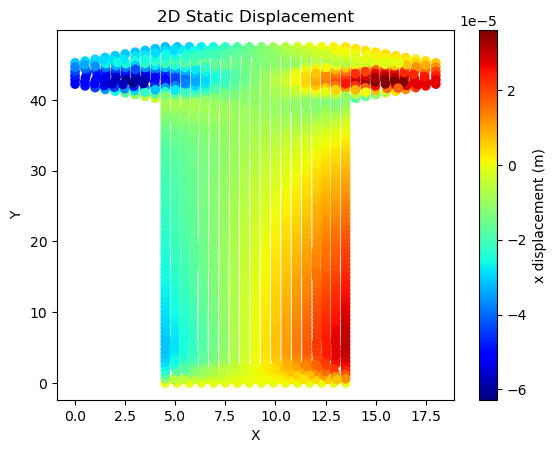

In [258]:
# Create a scatter plot
x = sorted_coordinates[:, 0]
y = sorted_coordinates[:, 1]
scatter = plt.scatter(x, y, c=C[::2], cmap='jet')  # 'c' assigns color based on temperature

# Add a color bar to represent the temperature scale
plt.colorbar(scatter, label='x displacement (m)')  # Optional label for the color bar

# Labels for axes
plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D Static Displacement')
# Show the plot
plt.show()

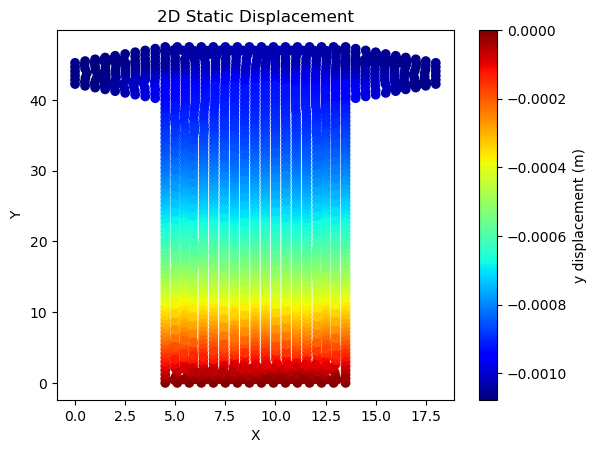

In [259]:
# Create a scatter plot
x = sorted_coordinates[:, 0]
y = sorted_coordinates[:, 1]
scatter = plt.scatter(x, y, c=C[1::2], cmap='jet')  # 'c' assigns color based on temperature

# Add a color bar to represent the temperature scale
plt.colorbar(scatter, label='y displacement (m)')  # Optional label for the color bar

# Labels for axes
plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D Static Displacement')
# Show the plot
plt.show()

In [260]:
stress, centroid = find_static_stress(C, total_nodes, node_tags, triangle, "tank2")

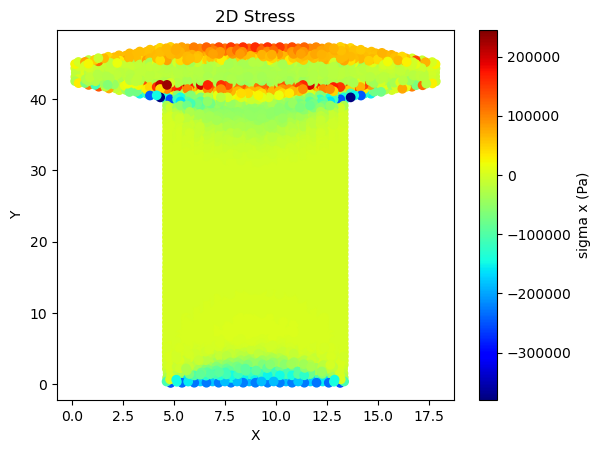

In [261]:
# Create a scatter plot
x = centroid[0, :]
y = centroid[1, :]
scatter = plt.scatter(x, y, c=stress[0,:], cmap='jet')  # 'c' assigns color based on temperature

# Add a color bar to represent the temperature scale
plt.colorbar(scatter, label='sigma x (Pa)')  # Optional label for the color bar

# Labels for axes
plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D Stress')
# Show the plot
plt.show()

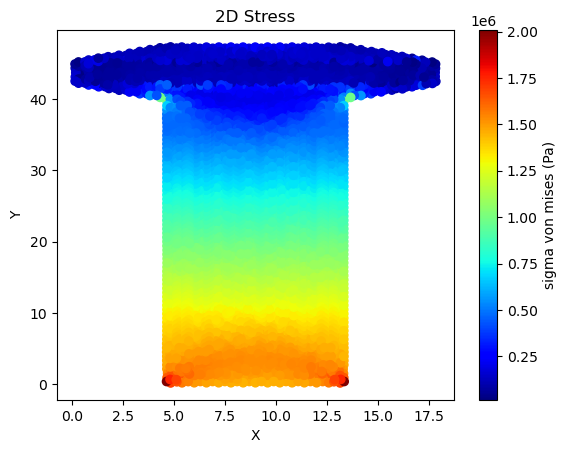

In [262]:
# Create a scatter plot
von_m = von_mises(stress)
x = centroid[0, :]
y = centroid[1, :]
scatter = plt.scatter(x, y, c=von_m[0,:], cmap='jet')  # 'c' assigns color based on temperature

# Add a color bar to represent the temperature scale
plt.colorbar(scatter, label='sigma von mises (Pa)')  # Optional label for the color bar

# Labels for axes
plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D Stress')
# Show the plot
plt.show()

**MESH CONVERGENCE TESTS**

TANK 1 - GYMKHANA 

*Static and without Helicopter*

In [146]:
num = [0.8, 0.5, 0.3, 0.22, 0.17]
point = np.array([3.6, 10])
sol_t1_s_wh = []
tta_t1_s_wh = []
# point_indices_total = []
# point_coordinates_final = []
dis_array_t1_s_wh = []
for i in range(len(num)):
    point_coordinates = []
    point_indices = []
    area = 0
    gmsh.initialize()

    # gmsh.open('IITM_Map_final')
    gmsh.open(f'tank1_sf_{num[i]}')

    # Unpack the three return values (nodeTags, coordinates, parametricCoordinates)
    nodeTags, coordinates, _ = gmsh.model.mesh.getNodes(-1, -1)

    # Total number of nodes is the length of nodeTags
    total_nodes = len(nodeTags)
    coordinates = coordinates.reshape((-1, 3))

    sorted_indices = np.argsort(nodeTags)
    sorted_coordinates = coordinates[sorted_indices]


    # coordinates = (gmsh.model.mesh.getNodes(-1,-1))[1].reshape((-1,3))
    dim = 2 #for triangles
    tag = -1 #get all
    ele_tags, node_tags = gmsh.model.mesh.getElementsByType(dim, tag)
    node_tags = node_tags.reshape((-1,3))
    node_tags[:,[1,2]] = node_tags[:, [2,1]]

    triangle = []
    ground = set()
    for tag, nodes in zip(ele_tags, node_tags):
        x1 , y1 = list(coordinates[int(nodes[0]-1),:-1])
        x2 , y2 = list(coordinates[int(nodes[1]-1),:-1])
        x3 , y3 = list(coordinates[int(nodes[2]-1),:-1])
        triangle.append([x1,y1,x2,y2,x3,y3])
        if y1 == 0:
            ground.add(2*(nodes[0] - 1))
            # print(nodes[0])
            ground.add(2*(nodes[0] - 1) +1)
        if y2 == 0:
            ground.add(2*(nodes[1]-1))
            # print(nodes[1])
            ground.add(2*(nodes[1]-1) + 1)
        if y3 == 0:
            ground.add(2*(nodes[2]-1))
            # print(nodes[2])
            ground.add(2*(nodes[2]-1)+1)
            

    triangle = np.array(triangle)
    ground = np.array(list(ground), dtype=int)


    gmsh.finalize()

    K = construct_B(total_nodes, node_tags, triangle, "tank1")
    f = construct_forcing(total_nodes, node_tags, triangle, "tank1")
    C_static = static_solution("dirichlet", total_nodes, ground, K, f)
    sol_t1_s_wh.append(C_static)
    tta_t1_s_wh.append(node_tags.shape[0])
    xy_coordinates = sorted_coordinates[:, :2]
    point_index = np.argmin(np.sum((xy_coordinates - point)**2, axis=1))
    # point_indices_total.append(point_index)
    # point_coordinates_final.append(sorted_coordinates[point_index])
    # print(point_coordinates)
    # x1, y1, x2, y2, x3, y3 = point_coordinates
    # coeff = np.array([[x2-x1, x3 - x1], [y2-y1, y3-y1]])
    # parametric = np.linalg.inv(coeff) @ np.array([[point[0] - x1], [point[1] - y1]])
    # temp_val = C_static[point_indices[0]] * (1 - parametric[0] - parametric[1]) + C_static[point_indices[1]] * (parametric[0]) + C_static[point_indices[2]] * (parametric[1])
    u_val = C_static[2*point_index]
    v_val = C_static[2*point_index + 1]
    dis_array_t1_s_wh.append(np.sqrt(u_val**2 + v_val**2))
    

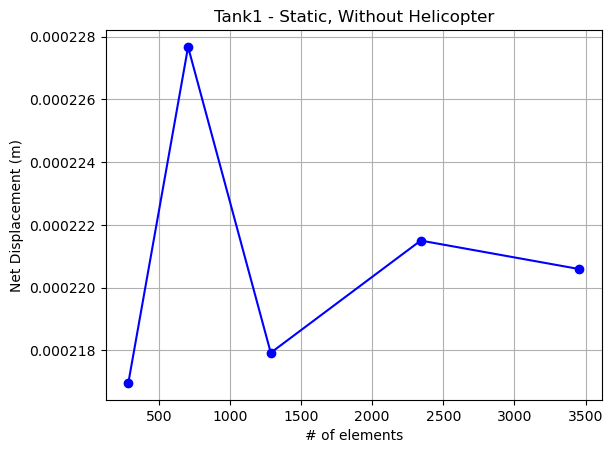

In [147]:
# plt.figure(figsize=(8, 5))  # Adjust figure size to match the first plot
plt.plot(tta_t1_s_wh, dis_array_t1_s_wh, marker='o', color='blue', linestyle='-', markersize=6)  # Set color, marker, and line style
# plt.xscale('log')  # Set x-axis to log scale
# plt.grid(True)  # Enable gridlines
plt.grid(True)
# plt.gca().set_aspect('equal', adjustable='box')  # Ensure gridlines are square
plt.xlabel("# of elements")  # X-axis label
plt.ylabel("Net Displacement (m)")  # Y-axis label
plt.title("Tank1 - Static, Without Helicopter")  # Title

plt.show()

*Static and with Helicopter*

In [88]:
num = [0.8, 0.5, 0.3, 0.22, 0.17]
point = np.array([3.6, 10])
sol_t1_s_h = []
tta_t1_s_h = []
# point_indices_total = []
# point_coordinates_final = []
dis_array_t1_s_h = []
for i in range(len(num)):
    point_coordinates = []
    point_indices = []
    area = 0
    gmsh.initialize()

    # gmsh.open('IITM_Map_final')
    gmsh.open(f'tank1_sf_{num[i]}')

    # Unpack the three return values (nodeTags, coordinates, parametricCoordinates)
    nodeTags, coordinates, _ = gmsh.model.mesh.getNodes(-1, -1)

    # Total number of nodes is the length of nodeTags
    total_nodes = len(nodeTags)
    coordinates = coordinates.reshape((-1, 3))

    sorted_indices = np.argsort(nodeTags)
    sorted_coordinates = coordinates[sorted_indices]


    # coordinates = (gmsh.model.mesh.getNodes(-1,-1))[1].reshape((-1,3))
    dim = 2 #for triangles
    tag = -1 #get all
    ele_tags, node_tags = gmsh.model.mesh.getElementsByType(dim, tag)
    node_tags = node_tags.reshape((-1,3))
    node_tags[:,[1,2]] = node_tags[:, [2,1]]

    triangle = []
    ground = set()
    for tag, nodes in zip(ele_tags, node_tags):
        x1 , y1 = list(coordinates[int(nodes[0]-1),:-1])
        x2 , y2 = list(coordinates[int(nodes[1]-1),:-1])
        x3 , y3 = list(coordinates[int(nodes[2]-1),:-1])
        triangle.append([x1,y1,x2,y2,x3,y3])
        if y1 == 0:
            ground.add(2*(nodes[0] - 1))
            # print(nodes[0])
            ground.add(2*(nodes[0] - 1) +1)
        if y2 == 0:
            ground.add(2*(nodes[1]-1))
            # print(nodes[1])
            ground.add(2*(nodes[1]-1) + 1)
        if y3 == 0:
            ground.add(2*(nodes[2]-1))
            # print(nodes[2])
            ground.add(2*(nodes[2]-1)+1)
            

    triangle = np.array(triangle)
    ground = np.array(list(ground), dtype=int)


    gmsh.finalize()

    K = construct_B(total_nodes, node_tags, triangle, "tank1")
    f = construct_forcing(total_nodes, node_tags, triangle, "tank1", "yes")
    C_static = static_solution("dirichlet", total_nodes, ground, K, f)
    sol_t1_s_h.append(C_static)
    tta_t1_s_h.append(node_tags.shape[0])
    xy_coordinates = sorted_coordinates[:, :2]
    point_index = np.argmin(np.sum((xy_coordinates - point)**2, axis=1))
    # point_indices_total.append(point_index)
    # point_coordinates_final.append(sorted_coordinates[point_index])
    # print(point_coordinates)
    # x1, y1, x2, y2, x3, y3 = point_coordinates
    # coeff = np.array([[x2-x1, x3 - x1], [y2-y1, y3-y1]])
    # parametric = np.linalg.inv(coeff) @ np.array([[point[0] - x1], [point[1] - y1]])
    # temp_val = C_static[point_indices[0]] * (1 - parametric[0] - parametric[1]) + C_static[point_indices[1]] * (parametric[0]) + C_static[point_indices[2]] * (parametric[1])
    u_val = C_static[2*point_index]
    v_val = C_static[2*point_index + 1]
    dis_array_t1_s_h.append(np.sqrt(u_val**2 + v_val**2))
    

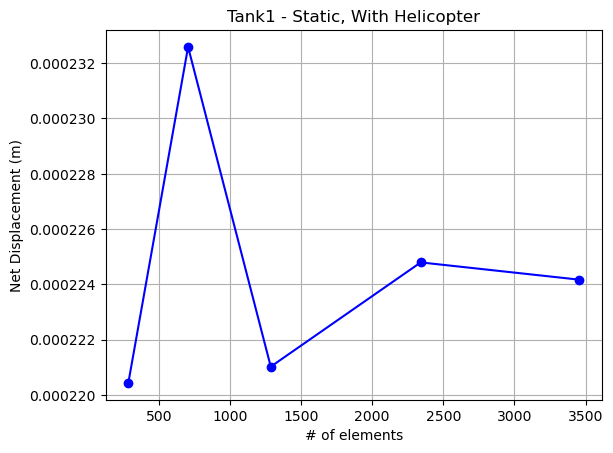

In [89]:
# plt.figure(figsize=(8, 5))  # Adjust figure size to match the first plot
plt.plot(tta_t1_s_h, dis_array_t1_s_h, marker='o', color='blue', linestyle='-', markersize=6)  # Set color, marker, and line style
# plt.xscale('log')  # Set x-axis to log scale
# plt.grid(True)  # Enable gridlines
plt.grid(True)
# plt.gca().set_aspect('equal', adjustable='box')  # Ensure gridlines are square
plt.xlabel("# of elements")  # X-axis label
plt.ylabel("Net Displacement (m)")  # Y-axis label
plt.title("Tank1 - Static, With Helicopter")  # Title

plt.show()

*Free Vibration without Helicopter*

In [122]:
num = [0.8, 0.5, 0.3, 0.22, 0.17]
tta_t1_v_wh = []
# point_indices_total = []
# point_coordinates_final = []
dis_array_t1_v_wh = []
for i in range(len(num)):
    point_coordinates = []
    point_indices = []
    area = 0
    gmsh.initialize()

    # gmsh.open('IITM_Map_final')
    gmsh.open(f'tank1_sf_{num[i]}')

    # Unpack the three return values (nodeTags, coordinates, parametricCoordinates)
    nodeTags, coordinates, _ = gmsh.model.mesh.getNodes(-1, -1)

    # Total number of nodes is the length of nodeTags
    total_nodes = len(nodeTags)
    coordinates = coordinates.reshape((-1, 3))

    sorted_indices = np.argsort(nodeTags)
    sorted_coordinates = coordinates[sorted_indices]


    # coordinates = (gmsh.model.mesh.getNodes(-1,-1))[1].reshape((-1,3))
    dim = 2 #for triangles
    tag = -1 #get all
    ele_tags, node_tags = gmsh.model.mesh.getElementsByType(dim, tag)
    node_tags = node_tags.reshape((-1,3))
    node_tags[:,[1,2]] = node_tags[:, [2,1]]

    triangle = []
    ground = set()
    for tag, nodes in zip(ele_tags, node_tags):
        x1 , y1 = list(coordinates[int(nodes[0]-1),:-1])
        x2 , y2 = list(coordinates[int(nodes[1]-1),:-1])
        x3 , y3 = list(coordinates[int(nodes[2]-1),:-1])
        triangle.append([x1,y1,x2,y2,x3,y3])
        if y1 == 0:
            ground.add(2*(nodes[0] - 1))
            # print(nodes[0])
            ground.add(2*(nodes[0] - 1) +1)
        if y2 == 0:
            ground.add(2*(nodes[1]-1))
            # print(nodes[1])
            ground.add(2*(nodes[1]-1) + 1)
        if y3 == 0:
            ground.add(2*(nodes[2]-1))
            # print(nodes[2])
            ground.add(2*(nodes[2]-1)+1)
            

    triangle = np.array(triangle)
    ground = np.array(list(ground), dtype=int)


    gmsh.finalize()

    K = construct_B(total_nodes, node_tags, triangle, "tank1")
    M = construct_mass(total_nodes, node_tags, triangle, "tank1")
    K_sub, M_sub, C_trans, unkown_indices = static_solution("submatrix", total_nodes, ground, K, None, M)
    eigenvalues, eigenvectors = cal_eigen(M_sub,K_sub)
    eigenvalues = np.sort(eigenvalues)
    
    norm = np.linalg.norm(eigenvalues[0:5])
    dis_array_t1_v_wh.append(norm)
    tta_t1_v_wh.append(node_tags.shape[0])

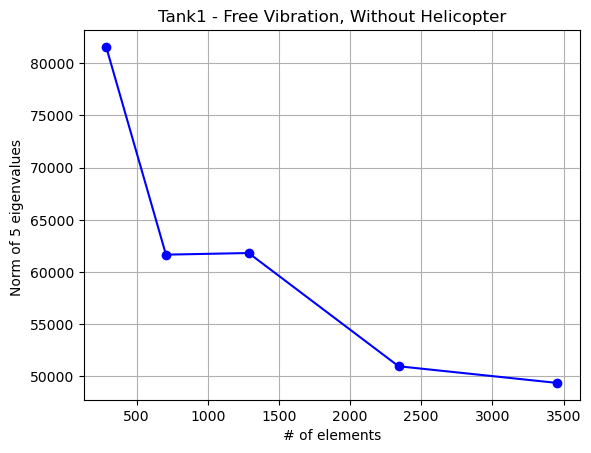

In [124]:
# plt.figure(figsize=(8, 5))  # Adjust figure size to match the first plot
plt.plot(tta_t1_v_wh, dis_array_t1_v_wh, marker='o', color='blue', linestyle='-', markersize=6)  # Set color, marker, and line style
# plt.xscale('log')  # Set x-axis to log scale
# plt.grid(True)  # Enable gridlines
plt.grid(True)
# plt.gca().set_aspect('equal', adjustable='box')  # Ensure gridlines are square
plt.xlabel("# of elements")  # X-axis label
plt.ylabel("Norm of 5 eigenvalues ")  # Y-axis label
plt.title("Tank1 - Free Vibration, Without Helicopter")  # Title

plt.show()

*Free Vibration with Helicopter*

In [125]:
num = [1, 0.6, 0.4, 0.25, 0.2]
tta_t1_v_h = []
# point_indices_total = []
# point_coordinates_final = []
dis_array_t1_v_h = []
for i in range(len(num)):
    point_coordinates = []
    point_indices = []
    area = 0
    gmsh.initialize()

    # gmsh.open('IITM_Map_final')
    gmsh.open(f'tank1_heli_sf_{num[i]}')

    # Unpack the three return values (nodeTags, coordinates, parametricCoordinates)
    nodeTags, coordinates, _ = gmsh.model.mesh.getNodes(-1, -1)

    # Total number of nodes is the length of nodeTags
    total_nodes = len(nodeTags)
    coordinates = coordinates.reshape((-1, 3))

    sorted_indices = np.argsort(nodeTags)
    sorted_coordinates = coordinates[sorted_indices]


    # coordinates = (gmsh.model.mesh.getNodes(-1,-1))[1].reshape((-1,3))
    dim = 2 #for triangles
    tag = -1 #get all
    ele_tags, node_tags = gmsh.model.mesh.getElementsByType(dim, tag)
    node_tags = node_tags.reshape((-1,3))
    node_tags[:,[1,2]] = node_tags[:, [2,1]]

    triangle = []
    ground = set()
    for tag, nodes in zip(ele_tags, node_tags):
        x1 , y1 = list(coordinates[int(nodes[0]-1),:-1])
        x2 , y2 = list(coordinates[int(nodes[1]-1),:-1])
        x3 , y3 = list(coordinates[int(nodes[2]-1),:-1])
        triangle.append([x1,y1,x2,y2,x3,y3])
        if y1 == 0:
            ground.add(2*(nodes[0] - 1))
            # print(nodes[0])
            ground.add(2*(nodes[0] - 1) +1)
        if y2 == 0:
            ground.add(2*(nodes[1]-1))
            # print(nodes[1])
            ground.add(2*(nodes[1]-1) + 1)
        if y3 == 0:
            ground.add(2*(nodes[2]-1))
            # print(nodes[2])
            ground.add(2*(nodes[2]-1)+1)
            

    triangle = np.array(triangle)
    ground = np.array(list(ground), dtype=int)


    gmsh.finalize()

    K = construct_B(total_nodes, node_tags, triangle, "tank1")
    M = construct_mass(total_nodes, node_tags, triangle, "tank1")
    K_sub, M_sub, C_trans, unkown_indices = static_solution("submatrix", total_nodes, ground, K, None, M)
    eigenvalues, eigenvectors = cal_eigen(M_sub,K_sub)
    eigenvalues = np.sort(eigenvalues)
    
    norm = np.linalg.norm(eigenvalues[0:5])
    dis_array_t1_v_h.append(norm)
    tta_t1_v_h.append(node_tags.shape[0])

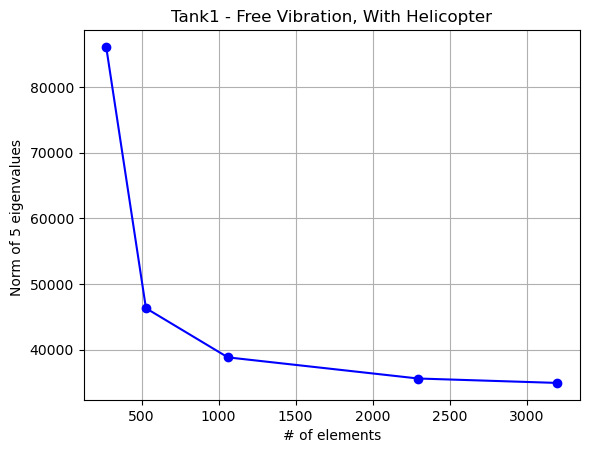

In [126]:
# plt.figure(figsize=(8, 5))  # Adjust figure size to match the first plot
plt.plot(tta_t1_v_h, dis_array_t1_v_h, marker='o', color='blue', linestyle='-', markersize=6)  # Set color, marker, and line style
# plt.xscale('log')  # Set x-axis to log scale
# plt.grid(True)  # Enable gridlines
plt.grid(True)
# plt.gca().set_aspect('equal', adjustable='box')  # Ensure gridlines are square
plt.xlabel("# of elements")  # X-axis label
plt.ylabel("Norm of 5 eigenvalues ")  # Y-axis label
plt.title("Tank1 - Free Vibration, With Helicopter")  # Title

plt.show()

TANK 2 - MSB

*Static and Without Helicopter*

In [263]:
num = [1.5, 1, 0.75, 0.6, 0.5]
point = np.array([5, 10])
sol_t2_s_wh = []
tta_t2_s_wh = []
# point_indices_total = []
# point_coordinates_final = []
dis_array_t2_s_wh = []
for i in range(len(num)):
    point_coordinates = []
    point_indices = []
    area = 0
    gmsh.initialize()

    # gmsh.open('IITM_Map_final')
    gmsh.open(f'msb_sf_{num[i]}')

    # Unpack the three return values (nodeTags, coordinates, parametricCoordinates)
    nodeTags, coordinates, _ = gmsh.model.mesh.getNodes(-1, -1)

    # Total number of nodes is the length of nodeTags
    total_nodes = len(nodeTags)
    coordinates = coordinates.reshape((-1, 3))

    sorted_indices = np.argsort(nodeTags)
    sorted_coordinates = coordinates[sorted_indices]


    # coordinates = (gmsh.model.mesh.getNodes(-1,-1))[1].reshape((-1,3))
    dim = 2 #for triangles
    tag = -1 #get all
    ele_tags, node_tags = gmsh.model.mesh.getElementsByType(dim, tag)
    node_tags = node_tags.reshape((-1,3))
    node_tags[:,[1,2]] = node_tags[:, [2,1]]

    triangle = []
    ground = set()
    for tag, nodes in zip(ele_tags, node_tags):
        x1 , y1 = list(coordinates[int(nodes[0]-1),:-1])
        x2 , y2 = list(coordinates[int(nodes[1]-1),:-1])
        x3 , y3 = list(coordinates[int(nodes[2]-1),:-1])
        triangle.append([x1,y1,x2,y2,x3,y3])
        if y1 == 0:
            ground.add(2*(nodes[0] - 1))
            # print(nodes[0])
            ground.add(2*(nodes[0] - 1) +1)
        if y2 == 0:
            ground.add(2*(nodes[1]-1))
            # print(nodes[1])
            ground.add(2*(nodes[1]-1) + 1)
        if y3 == 0:
            ground.add(2*(nodes[2]-1))
            # print(nodes[2])
            ground.add(2*(nodes[2]-1)+1)
            

    triangle = np.array(triangle)
    ground = np.array(list(ground), dtype=int)


    gmsh.finalize()

    K = construct_B(total_nodes, node_tags, triangle, "tank2")
    f = construct_forcing(total_nodes, node_tags, triangle, "tank2")
    C_static = static_solution("dirichlet", total_nodes, ground, K, f)
    sol_t2_s_wh.append(C_static)
    tta_t2_s_wh.append(node_tags.shape[0])
    xy_coordinates = sorted_coordinates[:, :2]
    point_index = np.argmin(np.sum((xy_coordinates - point)**2, axis=1))
    # point_indices_total.append(point_index)
    # point_coordinates_final.append(sorted_coordinates[point_index])
    # print(point_coordinates)
    # x1, y1, x2, y2, x3, y3 = point_coordinates
    # coeff = np.array([[x2-x1, x3 - x1], [y2-y1, y3-y1]])
    # parametric = np.linalg.inv(coeff) @ np.array([[point[0] - x1], [point[1] - y1]])
    # temp_val = C_static[point_indices[0]] * (1 - parametric[0] - parametric[1]) + C_static[point_indices[1]] * (parametric[0]) + C_static[point_indices[2]] * (parametric[1])
    u_val = C_static[2*point_index]
    v_val = C_static[2*point_index + 1]
    dis_array_t2_s_wh.append(np.sqrt(u_val**2 + v_val**2))

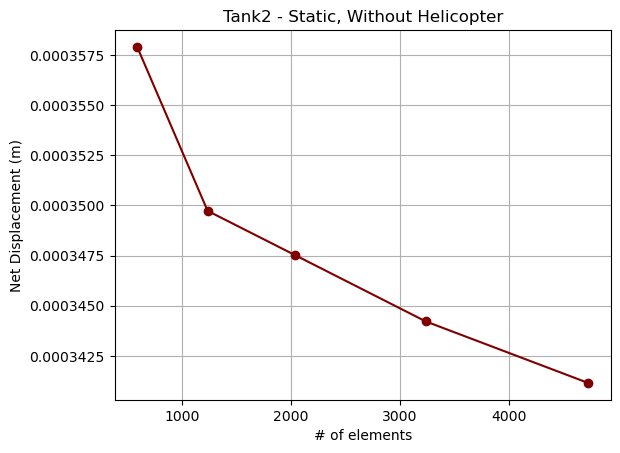

In [264]:
# plt.figure(figsize=(8, 5))  # Adjust figure size to match the first plot
plt.plot(tta_t2_s_wh, dis_array_t2_s_wh, marker='o', color='maroon', linestyle='-', markersize=6)  # Set color, marker, and line style
# plt.xscale('log')  # Set x-axis to log scale
# plt.grid(True)  # Enable gridlines
plt.grid(True)
# plt.gca().set_aspect('equal', adjustable='box')  # Ensure gridlines are square
plt.xlabel("# of elements")  # X-axis label
plt.ylabel("Net Displacement (m)")  # Y-axis label
plt.title("Tank2 - Static, Without Helicopter")  # Title

plt.show()

*Static and With Helicopter*

In [265]:
num = [1.5, 1, 0.75, 0.6, 0.5]
point = np.array([5, 10])
sol_t2_s_h = []
tta_t2_s_h = []
# point_indices_total = []
# point_coordinates_final = []
dis_array_t2_s_h = []
for i in range(len(num)):
    point_coordinates = []
    point_indices = []
    area = 0
    gmsh.initialize()

    # gmsh.open('IITM_Map_final')
    gmsh.open(f'msb_sf_{num[i]}')

    # Unpack the three return values (nodeTags, coordinates, parametricCoordinates)
    nodeTags, coordinates, _ = gmsh.model.mesh.getNodes(-1, -1)

    # Total number of nodes is the length of nodeTags
    total_nodes = len(nodeTags)
    coordinates = coordinates.reshape((-1, 3))

    sorted_indices = np.argsort(nodeTags)
    sorted_coordinates = coordinates[sorted_indices]


    # coordinates = (gmsh.model.mesh.getNodes(-1,-1))[1].reshape((-1,3))
    dim = 2 #for triangles
    tag = -1 #get all
    ele_tags, node_tags = gmsh.model.mesh.getElementsByType(dim, tag)
    node_tags = node_tags.reshape((-1,3))
    node_tags[:,[1,2]] = node_tags[:, [2,1]]

    triangle = []
    ground = set()
    for tag, nodes in zip(ele_tags, node_tags):
        x1 , y1 = list(coordinates[int(nodes[0]-1),:-1])
        x2 , y2 = list(coordinates[int(nodes[1]-1),:-1])
        x3 , y3 = list(coordinates[int(nodes[2]-1),:-1])
        triangle.append([x1,y1,x2,y2,x3,y3])
        if y1 == 0:
            ground.add(2*(nodes[0] - 1))
            # print(nodes[0])
            ground.add(2*(nodes[0] - 1) +1)
        if y2 == 0:
            ground.add(2*(nodes[1]-1))
            # print(nodes[1])
            ground.add(2*(nodes[1]-1) + 1)
        if y3 == 0:
            ground.add(2*(nodes[2]-1))
            # print(nodes[2])
            ground.add(2*(nodes[2]-1)+1)
            

    triangle = np.array(triangle)
    ground = np.array(list(ground), dtype=int)


    gmsh.finalize()

    K = construct_B(total_nodes, node_tags, triangle, "tank2")
    f = construct_forcing(total_nodes, node_tags, triangle, "tank2", "yes")
    C_static = static_solution("dirichlet", total_nodes, ground, K, f)
    sol_t2_s_h.append(C_static)
    tta_t2_s_h.append(node_tags.shape[0])
    xy_coordinates = sorted_coordinates[:, :2]
    point_index = np.argmin(np.sum((xy_coordinates - point)**2, axis=1))
    # point_indices_total.append(point_index)
    # point_coordinates_final.append(sorted_coordinates[point_index])
    # print(point_coordinates)
    # x1, y1, x2, y2, x3, y3 = point_coordinates
    # coeff = np.array([[x2-x1, x3 - x1], [y2-y1, y3-y1]])
    # parametric = np.linalg.inv(coeff) @ np.array([[point[0] - x1], [point[1] - y1]])
    # temp_val = C_static[point_indices[0]] * (1 - parametric[0] - parametric[1]) + C_static[point_indices[1]] * (parametric[0]) + C_static[point_indices[2]] * (parametric[1])
    u_val = C_static[2*point_index]
    v_val = C_static[2*point_index + 1]
    dis_array_t2_s_h.append(np.sqrt(u_val**2 + v_val**2))

Text(0.5, 1.0, 'Tank2 - Static, With Helicopter')

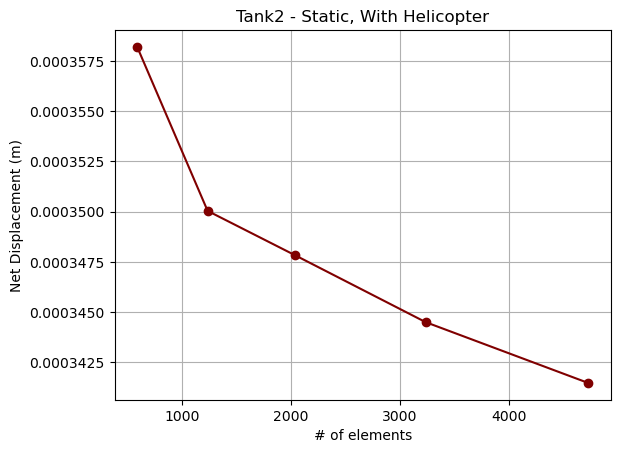

In [266]:
# plt.figure(figsize=(8, 5))  # Adjust figure size to match the first plot
plt.plot(tta_t2_s_h, dis_array_t2_s_h, marker='o', color='maroon', linestyle='-', markersize=6)  # Set color, marker, and line style
# plt.xscale('log')  # Set x-axis to log scale
# plt.grid(True)  # Enable gridlines
plt.grid(True)
# plt.gca().set_aspect('equal', adjustable='box')  # Ensure gridlines are square
plt.xlabel("# of elements")  # X-axis label
plt.ylabel("Net Displacement (m)")  # Y-axis label
plt.title("Tank2 - Static, With Helicopter")  # Title

*Free Vibration without Helicopter*

In [267]:
num = [1.5, 1, 0.75, 0.6, 0.5]
tta_t2_v_wh = []
# point_indices_total = []
# point_coordinates_final = []
dis_array_t2_v_wh = []
for i in range(len(num)):
    point_coordinates = []
    point_indices = []
    area = 0
    gmsh.initialize()

    # gmsh.open('IITM_Map_final')
    gmsh.open(f'msb_sf_{num[i]}')

    # Unpack the three return values (nodeTags, coordinates, parametricCoordinates)
    nodeTags, coordinates, _ = gmsh.model.mesh.getNodes(-1, -1)

    # Total number of nodes is the length of nodeTags
    total_nodes = len(nodeTags)
    coordinates = coordinates.reshape((-1, 3))

    sorted_indices = np.argsort(nodeTags)
    sorted_coordinates = coordinates[sorted_indices]


    # coordinates = (gmsh.model.mesh.getNodes(-1,-1))[1].reshape((-1,3))
    dim = 2 #for triangles
    tag = -1 #get all
    ele_tags, node_tags = gmsh.model.mesh.getElementsByType(dim, tag)
    node_tags = node_tags.reshape((-1,3))
    node_tags[:,[1,2]] = node_tags[:, [2,1]]

    triangle = []
    ground = set()
    for tag, nodes in zip(ele_tags, node_tags):
        x1 , y1 = list(coordinates[int(nodes[0]-1),:-1])
        x2 , y2 = list(coordinates[int(nodes[1]-1),:-1])
        x3 , y3 = list(coordinates[int(nodes[2]-1),:-1])
        triangle.append([x1,y1,x2,y2,x3,y3])
        if y1 == 0:
            ground.add(2*(nodes[0] - 1))
            # print(nodes[0])
            ground.add(2*(nodes[0] - 1) +1)
        if y2 == 0:
            ground.add(2*(nodes[1]-1))
            # print(nodes[1])
            ground.add(2*(nodes[1]-1) + 1)
        if y3 == 0:
            ground.add(2*(nodes[2]-1))
            # print(nodes[2])
            ground.add(2*(nodes[2]-1)+1)
            

    triangle = np.array(triangle)
    ground = np.array(list(ground), dtype=int)


    gmsh.finalize()

    K = construct_B(total_nodes, node_tags, triangle, "tank2")
    M = construct_mass(total_nodes, node_tags, triangle, "tank2")
    K_sub, M_sub, C_trans, unkown_indices = static_solution("submatrix", total_nodes, ground, K, None, M)
    eigenvalues, eigenvectors = cal_eigen(M_sub,K_sub)
    eigenvalues = np.sort(eigenvalues)
    
    norm = np.linalg.norm(eigenvalues[0:5])
    dis_array_t2_v_wh.append(norm)
    tta_t2_v_wh.append(node_tags.shape[0])

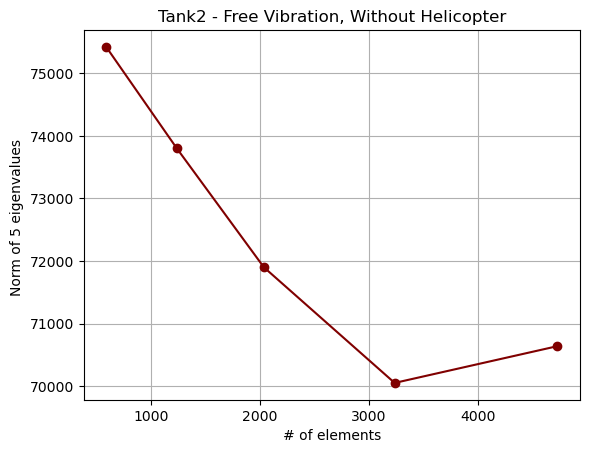

In [268]:
# plt.figure(figsize=(8, 5))  # Adjust figure size to match the first plot
plt.plot(tta_t2_v_wh, dis_array_t2_v_wh, marker='o', color='maroon', linestyle='-', markersize=6)  # Set color, marker, and line style
# plt.xscale('log')  # Set x-axis to log scale
# plt.grid(True)  # Enable gridlines
plt.grid(True)
# plt.gca().set_aspect('equal', adjustable='box')  # Ensure gridlines are square
plt.xlabel("# of elements")  # X-axis label
plt.ylabel("Norm of 5 eigenvalues ")  # Y-axis label
plt.title("Tank2 - Free Vibration, Without Helicopter")  # Title

plt.show()

*Tank2 - Free Vibration with Helicopter*

In [269]:
num = [1.5, 1, 0.75, 0.6, 0.5]
tta_t2_v_h = []
# point_indices_total = []
# point_coordinates_final = []
dis_array_t2_v_h = []
for i in range(len(num)):
    point_coordinates = []
    point_indices = []
    area = 0
    gmsh.initialize()

    # gmsh.open('IITM_Map_final')
    gmsh.open(f'msb_heli_sf_{num[i]}')

    # Unpack the three return values (nodeTags, coordinates, parametricCoordinates)
    nodeTags, coordinates, _ = gmsh.model.mesh.getNodes(-1, -1)

    # Total number of nodes is the length of nodeTags
    total_nodes = len(nodeTags)
    coordinates = coordinates.reshape((-1, 3))

    sorted_indices = np.argsort(nodeTags)
    sorted_coordinates = coordinates[sorted_indices]


    # coordinates = (gmsh.model.mesh.getNodes(-1,-1))[1].reshape((-1,3))
    dim = 2 #for triangles
    tag = -1 #get all
    ele_tags, node_tags = gmsh.model.mesh.getElementsByType(dim, tag)
    node_tags = node_tags.reshape((-1,3))
    node_tags[:,[1,2]] = node_tags[:, [2,1]]

    triangle = []
    ground = set()
    for tag, nodes in zip(ele_tags, node_tags):
        x1 , y1 = list(coordinates[int(nodes[0]-1),:-1])
        x2 , y2 = list(coordinates[int(nodes[1]-1),:-1])
        x3 , y3 = list(coordinates[int(nodes[2]-1),:-1])
        triangle.append([x1,y1,x2,y2,x3,y3])
        if y1 == 0:
            ground.add(2*(nodes[0] - 1))
            # print(nodes[0])
            ground.add(2*(nodes[0] - 1) +1)
        if y2 == 0:
            ground.add(2*(nodes[1]-1))
            # print(nodes[1])
            ground.add(2*(nodes[1]-1) + 1)
        if y3 == 0:
            ground.add(2*(nodes[2]-1))
            # print(nodes[2])
            ground.add(2*(nodes[2]-1)+1)
            

    triangle = np.array(triangle)
    ground = np.array(list(ground), dtype=int)


    gmsh.finalize()

    K = construct_B(total_nodes, node_tags, triangle, "tank2")
    M = construct_mass(total_nodes, node_tags, triangle, "tank2")
    K_sub, M_sub, C_trans, unkown_indices = static_solution("submatrix", total_nodes, ground, K, None, M)
    eigenvalues, eigenvectors = cal_eigen(M_sub,K_sub)
    eigenvalues = np.sort(eigenvalues)
    
    norm = np.linalg.norm(eigenvalues[0:5])
    dis_array_t2_v_h.append(norm)
    tta_t2_v_h.append(node_tags.shape[0])

Text(0.5, 1.0, 'Tank2 - Free Vibration, With Helicopter')

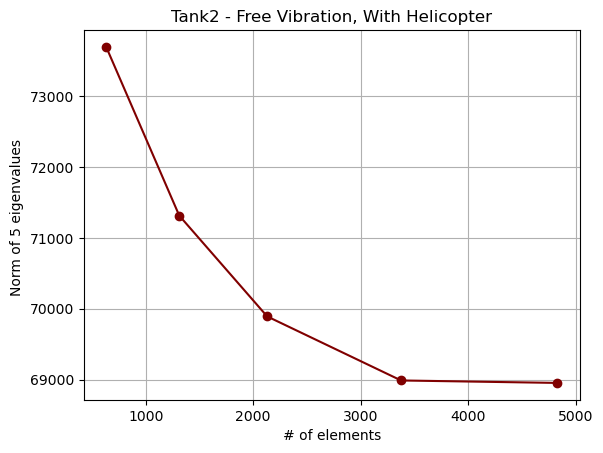

In [270]:
# plt.figure(figsize=(8, 5))  # Adjust figure size to match the first plot
plt.plot(tta_t2_v_h, dis_array_t2_v_h, marker='o', color='maroon', linestyle='-', markersize=6)  # Set color, marker, and line style
# plt.xscale('log')  # Set x-axis to log scale
# plt.grid(True)  # Enable gridlines
plt.grid(True)
# plt.gca().set_aspect('equal', adjustable='box')  # Ensure gridlines are square
plt.xlabel("# of elements")  # X-axis label
plt.ylabel("Norm of 5 eigenvalues ")  # Y-axis label
plt.title("Tank2 - Free Vibration, With Helicopter")  # Title

**Maximum Stress Calculation**

We are Observing only Static Case for Maximum Stress Calculation

In [271]:
tank1_files = ['tank1_sf_0.22', 'tank1_heli_sf_0.25']
tank2_files = ['msb_sf_0.6', 'msb_heli_sf_0.6']

In [272]:
sol_t1_max_stress = []
von_mises_stress_t1 = []
stress_t1 = []
centroid_t1 = []
coordinates_t1 = []
# point_indices_total = []
# point_coordinates_final = []
for i in range(len(tank1_files)):
    point_coordinates = []
    point_indices = []
    area = 0
    gmsh.initialize()

    # gmsh.open('IITM_Map_final')
    gmsh.open(tank1_files[0])

    # Unpack the three return values (nodeTags, coordinates, parametricCoordinates)
    nodeTags, coordinates, _ = gmsh.model.mesh.getNodes(-1, -1)

    # Total number of nodes is the length of nodeTags
    total_nodes = len(nodeTags)
    coordinates = coordinates.reshape((-1, 3))

    sorted_indices = np.argsort(nodeTags)
    sorted_coordinates = coordinates[sorted_indices]


    # coordinates = (gmsh.model.mesh.getNodes(-1,-1))[1].reshape((-1,3))
    dim = 2 #for triangles
    tag = -1 #get all
    ele_tags, node_tags = gmsh.model.mesh.getElementsByType(dim, tag)
    node_tags = node_tags.reshape((-1,3))
    node_tags[:,[1,2]] = node_tags[:, [2,1]]

    triangle = []
    ground = set()
    for tag, nodes in zip(ele_tags, node_tags):
        x1 , y1 = list(coordinates[int(nodes[0]-1),:-1])
        x2 , y2 = list(coordinates[int(nodes[1]-1),:-1])
        x3 , y3 = list(coordinates[int(nodes[2]-1),:-1])
        triangle.append([x1,y1,x2,y2,x3,y3])
        if y1 == 0:
            ground.add(2*(nodes[0] - 1))
            # print(nodes[0])
            ground.add(2*(nodes[0] - 1) +1)
        if y2 == 0:
            ground.add(2*(nodes[1]-1))
            # print(nodes[1])
            ground.add(2*(nodes[1]-1) + 1)
        if y3 == 0:
            ground.add(2*(nodes[2]-1))
            # print(nodes[2])
            ground.add(2*(nodes[2]-1)+1)
            

    triangle = np.array(triangle)
    ground = np.array(list(ground), dtype=int)


    gmsh.finalize()

    K = construct_B(total_nodes, node_tags, triangle, "tank1")
    if i == 0:
        f = construct_forcing(total_nodes, node_tags, triangle, "tank1")
    else:
        f = construct_forcing(total_nodes, node_tags, triangle, "tank1", "yes")
        
    C_static = static_solution("dirichlet", total_nodes, ground, K, f)
    sol_t1_max_stress.append(C_static)
    stress, centroid = find_static_stress(C_static, total_nodes, node_tags, triangle, "tank1")
    v_stress = von_mises(stress)
    stress_t1.append(stress)
    von_mises_stress_t1.append(v_stress)
    centroid_t1.append(centroid)
    coordinates_t1.append(sorted_coordinates)

In [273]:
sol_t2_max_stress = []
stress_t2 = []
von_mises_stress_t2 = []
centroid_t2 = []
coordinates_t2 = []
# point_indices_total = []
# point_coordinates_final = []
for i in range(len(tank2_files)):
    gmsh.initialize()

    # gmsh.open('IITM_Map_final')
    gmsh.open(tank2_files[0])

    # Unpack the three return values (nodeTags, coordinates, parametricCoordinates)
    nodeTags, coordinates, _ = gmsh.model.mesh.getNodes(-1, -1)

    # Total number of nodes is the length of nodeTags
    total_nodes = len(nodeTags)
    coordinates = coordinates.reshape((-1, 3))

    sorted_indices = np.argsort(nodeTags)
    sorted_coordinates = coordinates[sorted_indices]


    # coordinates = (gmsh.model.mesh.getNodes(-1,-1))[1].reshape((-1,3))
    dim = 2 #for triangles
    tag = -1 #get all
    ele_tags, node_tags = gmsh.model.mesh.getElementsByType(dim, tag)
    node_tags = node_tags.reshape((-1,3))
    node_tags[:,[1,2]] = node_tags[:, [2,1]]

    triangle = []
    ground = set()
    for tag, nodes in zip(ele_tags, node_tags):
        x1 , y1 = list(coordinates[int(nodes[0]-1),:-1])
        x2 , y2 = list(coordinates[int(nodes[1]-1),:-1])
        x3 , y3 = list(coordinates[int(nodes[2]-1),:-1])
        triangle.append([x1,y1,x2,y2,x3,y3])
        if y1 == 0:
            ground.add(2*(nodes[0] - 1))
            # print(nodes[0])
            ground.add(2*(nodes[0] - 1) +1)
        if y2 == 0:
            ground.add(2*(nodes[1]-1))
            # print(nodes[1])
            ground.add(2*(nodes[1]-1) + 1)
        if y3 == 0:
            ground.add(2*(nodes[2]-1))
            # print(nodes[2])
            ground.add(2*(nodes[2]-1)+1)
            

    triangle = np.array(triangle)
    ground = np.array(list(ground), dtype=int)


    gmsh.finalize()

    K = construct_B(total_nodes, node_tags, triangle, "tank2")
    if i == 0:
        f = construct_forcing(total_nodes, node_tags, triangle, "tank2")
    else:
        f = construct_forcing(total_nodes, node_tags, triangle, "tank2", "yes")
        
    C_static = static_solution("dirichlet", total_nodes, ground, K, f)
    sol_t2_max_stress.append(C_static)
    stress, centroid = find_static_stress(C_static, total_nodes, node_tags, triangle, "tank2")
    v_stress = von_mises(stress)
    stress_t2.append(stress)
    von_mises_stress_t2.append(v_stress)
    centroid_t2.append(centroid)
    coordinates_t2.append(sorted_coordinates)

x coordinate: 3.671876301541046   y coordinate: 0.21170544019335946
Maximum Stress value: 1182996.7266834772 (Pa)


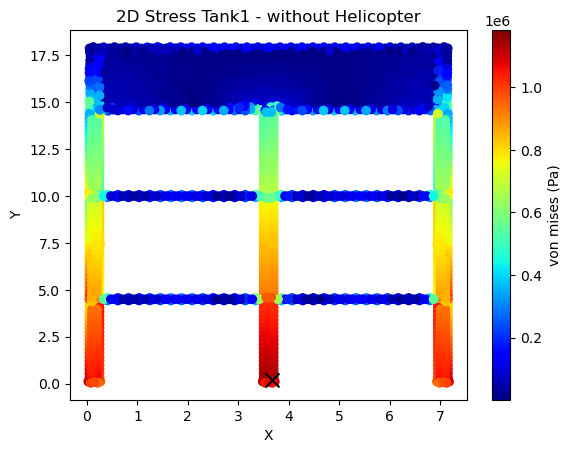

In [274]:
# Assuming von_m is already calculated from the `stress` vector
von_m = von_mises_stress_t1[0]

# Coordinates of the centroids
x = centroid_t1[0][0, :]
y = centroid_t1[0][1, :]

# Find the index of the maximum stress value
max_stress_index = np.argmax(von_m[0, :])
print("x coordinate:" , x[max_stress_index], "  y coordinate:", y[max_stress_index])
max_x = x[max_stress_index]
max_y = y[max_stress_index]
max_stress_value = von_m[0, max_stress_index]
print("Maximum Stress value:", max_stress_value, "(Pa)")

# Create a scatter plot of stress distribution
scatter = plt.scatter(x, y, c=von_m[0, :], cmap='jet')
plt.colorbar(scatter, label='von mises (Pa)')

# Highlight the point with the maximum stress
plt.scatter(max_x, max_y, color='black', s=100, marker='x')
# plt.text(max_x, max_y, f'({max_x:.2f}, {max_y:.2f})', color='red', fontsize=10)

# Labels for axes
plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D Stress Tank1 - without Helicopter')

# Show the legend
# plt.legend()

# Show the plot
plt.show()

x coordinate: 3.671876301541046   y coordinate: 0.21170544019335946
Maximum Stress value: 1197502.6550468132 (Pa)


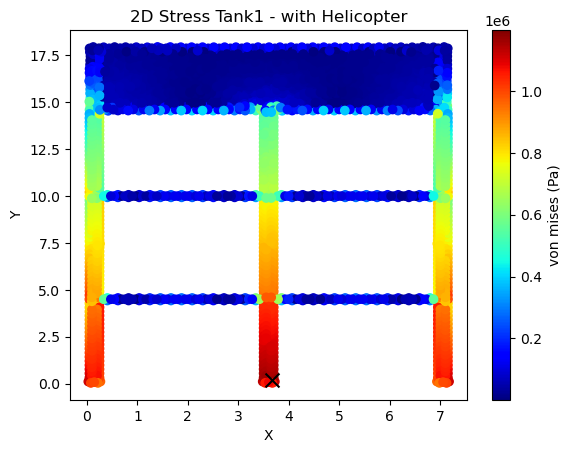

In [275]:
# Assuming von_m is already calculated from the `stress` vector
von_m = von_mises_stress_t1[1]

# Coordinates of the centroids
x = centroid_t1[1][0, :]
y = centroid_t1[1][1, :]

# Find the index of the maximum stress value
max_stress_index = np.argmax(von_m[0, :])
print("x coordinate:" , x[max_stress_index], "  y coordinate:", y[max_stress_index])

max_x = x[max_stress_index]
max_y = y[max_stress_index]
max_stress_value = von_m[0, max_stress_index]
print("Maximum Stress value:", max_stress_value, "(Pa)")

# Create a scatter plot of stress distribution
scatter = plt.scatter(x, y, c=von_m[0, :], cmap='jet')
plt.colorbar(scatter, label='von mises (Pa)')

# Highlight the point with the maximum stress
plt.scatter(max_x, max_y, color='black', s=100, marker='x')
# plt.text(max_x, max_y, f'({max_x:.2f}, {max_y:.2f})', color='red', fontsize=10)

# Labels for axes
plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D Stress Tank1 - with Helicopter')

# Show the legend
# plt.legend()

# Show the plot
plt.show()

x coordinate: 4.645780071594857   y coordinate: 0.34451643463936305
Maximum Stress value: 2007955.0153937642 (Pa)


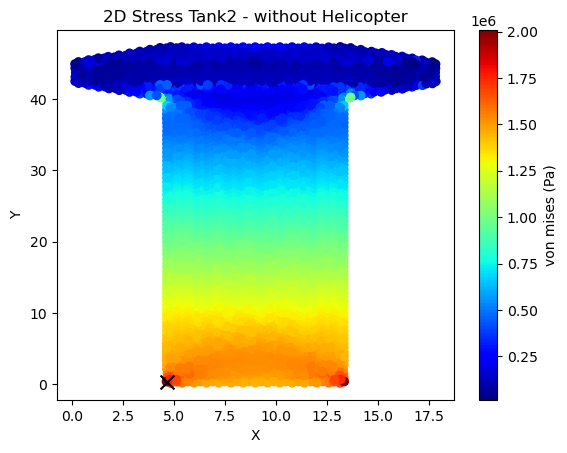

In [276]:
# Assuming von_m is already calculated from the `stress` vector
von_m = von_mises_stress_t2[0]

# Coordinates of the centroids
x = centroid_t2[0][0, :]
y = centroid_t2[0][1, :]

# Find the index of the maximum stress value
max_stress_index = np.argmax(von_m[0, :])
print("x coordinate:" , x[max_stress_index], "  y coordinate:", y[max_stress_index])

max_x = x[max_stress_index]
max_y = y[max_stress_index]
max_stress_value = von_m[0, max_stress_index]
print("Maximum Stress value:", max_stress_value, "(Pa)")

# Create a scatter plot of stress distribution
scatter = plt.scatter(x, y, c=von_m[0, :], cmap='jet')
plt.colorbar(scatter, label='von mises (Pa)')

# Highlight the point with the maximum stress
plt.scatter(max_x, max_y, color='black', s=100, marker='x')
# plt.text(max_x, max_y, f'({max_x:.2f}, {max_y:.2f})', color='red', fontsize=10)

# Labels for axes
plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D Stress Tank2 - without Helicopter')

# Show the legend
# plt.legend()

# Show the plot
plt.show()

x coordinate: 4.645780071594857   y coordinate: 0.34451643463936305
Maximum Stress value: 2009444.469589855 (Pa)


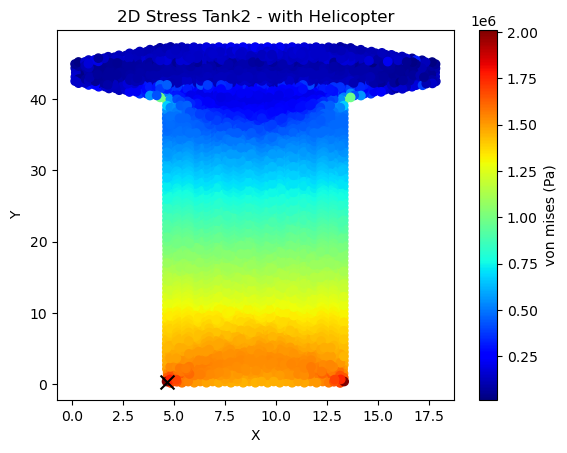

In [277]:
# Assuming von_m is already calculated from the `stress` vector
von_m = von_mises_stress_t2[1]

# Coordinates of the centroids
x = centroid_t2[1][0, :]
y = centroid_t2[1][1, :]

# Find the index of the maximum stress value
max_stress_index = np.argmax(von_m[0, :])
print("x coordinate:" , x[max_stress_index], "  y coordinate:", y[max_stress_index])

max_x = x[max_stress_index]
max_y = y[max_stress_index]
max_stress_value = von_m[0, max_stress_index]
print("Maximum Stress value:", max_stress_value, "(Pa)")

# Create a scatter plot of stress distribution
scatter = plt.scatter(x, y, c=von_m[0, :], cmap='jet')
plt.colorbar(scatter, label='von mises (Pa)')

# Highlight the point with the maximum stress
plt.scatter(max_x, max_y, color='black', s=100, marker='x')
# plt.text(max_x, max_y, f'({max_x:.2f}, {max_y:.2f})', color='red', fontsize=10)

# Labels for axes
plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D Stress Tank2 - with Helicopter')

# Show the legend
# plt.legend()

# Show the plot
plt.show()

**Fundamental Frequencies**

In [314]:
eigenvalues_t1 = []
eigenvectors_t1 = []
uk_i_t1 = []
total_nodes_t1 = []
# point_indices_total = []
# point_coordinates_final = []
for i in range(len(tank1_files)):
    point_coordinates = []
    point_indices = []
    area = 0
    gmsh.initialize()

    # gmsh.open('IITM_Map_final')
    gmsh.open(tank1_files[i])

    # Unpack the three return values (nodeTags, coordinates, parametricCoordinates)
    nodeTags, coordinates, _ = gmsh.model.mesh.getNodes(-1, -1)

    # Total number of nodes is the length of nodeTags
    total_nodes = len(nodeTags)
    coordinates = coordinates.reshape((-1, 3))

    sorted_indices = np.argsort(nodeTags)
    sorted_coordinates = coordinates[sorted_indices]


    # coordinates = (gmsh.model.mesh.getNodes(-1,-1))[1].reshape((-1,3))
    dim = 2 #for triangles
    tag = -1 #get all
    ele_tags, node_tags = gmsh.model.mesh.getElementsByType(dim, tag)
    node_tags = node_tags.reshape((-1,3))
    node_tags[:,[1,2]] = node_tags[:, [2,1]]

    triangle = []
    ground = set()
    for tag, nodes in zip(ele_tags, node_tags):
        x1 , y1 = list(coordinates[int(nodes[0]-1),:-1])
        x2 , y2 = list(coordinates[int(nodes[1]-1),:-1])
        x3 , y3 = list(coordinates[int(nodes[2]-1),:-1])
        triangle.append([x1,y1,x2,y2,x3,y3])
        if y1 == 0:
            ground.add(2*(nodes[0] - 1))
            # print(nodes[0])
            ground.add(2*(nodes[0] - 1) +1)
        if y2 == 0:
            ground.add(2*(nodes[1]-1))
            # print(nodes[1])
            ground.add(2*(nodes[1]-1) + 1)
        if y3 == 0:
            ground.add(2*(nodes[2]-1))
            # print(nodes[2])
            ground.add(2*(nodes[2]-1)+1)
            

    triangle = np.array(triangle)
    ground = np.array(list(ground), dtype=int)


    gmsh.finalize()

    K = construct_B(total_nodes, node_tags, triangle, "tank1")
    M = construct_mass(total_nodes, node_tags, triangle, "tank1")
    K_sub, M_sub, C_trans, unkown_indices = static_solution("submatrix", total_nodes, ground, K, None, M)
    eigenvalues, eigenvectors = cal_eigen(M_sub,K_sub)
    eigenvalues_t1.append(eigenvalues)
    eigenvectors_t1.append(eigenvectors)
    uk_i_t1.append(unkown_indices)
    total_nodes_t1.append(total_nodes)

In [315]:
eigenvalues_t2 = []
eigenvectors_t2 = []
uk_i_t2 = []
total_nodes_t2 = []
# point_indices_total = []
# point_coordinates_final = []
for i in range(len(tank2_files)):
    point_coordinates = []
    point_indices = []
    area = 0
    gmsh.initialize()

    # gmsh.open('IITM_Map_final')
    gmsh.open(tank2_files[i])

    # Unpack the three return values (nodeTags, coordinates, parametricCoordinates)
    nodeTags, coordinates, _ = gmsh.model.mesh.getNodes(-1, -1)

    # Total number of nodes is the length of nodeTags
    total_nodes = len(nodeTags)
    coordinates = coordinates.reshape((-1, 3))

    sorted_indices = np.argsort(nodeTags)
    sorted_coordinates = coordinates[sorted_indices]
    C_val = np.zeros((2*total_nodes,1))

    # coordinates = (gmsh.model.mesh.getNodes(-1,-1))[1].reshape((-1,3))
    dim = 2 #for triangles
    tag = -1 #get all
    ele_tags, node_tags = gmsh.model.mesh.getElementsByType(dim, tag)
    node_tags = node_tags.reshape((-1,3))
    node_tags[:,[1,2]] = node_tags[:, [2,1]]

    triangle = []
    ground = set()
    for tag, nodes in zip(ele_tags, node_tags):
        x1 , y1 = list(coordinates[int(nodes[0]-1),:-1])
        x2 , y2 = list(coordinates[int(nodes[1]-1),:-1])
        x3 , y3 = list(coordinates[int(nodes[2]-1),:-1])
        triangle.append([x1,y1,x2,y2,x3,y3])
        if y1 == 0:
            ground.add(2*(nodes[0] - 1))
            # print(nodes[0])
            ground.add(2*(nodes[0] - 1) +1)
        if y2 == 0:
            ground.add(2*(nodes[1]-1))
            # print(nodes[1])
            ground.add(2*(nodes[1]-1) + 1)
        if y3 == 0:
            ground.add(2*(nodes[2]-1))
            # print(nodes[2])
            ground.add(2*(nodes[2]-1)+1)
            

    triangle = np.array(triangle)
    ground = np.array(list(ground), dtype=int)


    gmsh.finalize()

    K = construct_B(total_nodes, node_tags, triangle, "tank2")
    M = construct_mass(total_nodes, node_tags, triangle, "tank2")
    K_sub, M_sub, C_trans, unkown_indices = static_solution("submatrix", total_nodes, ground, K, None, M)
    eigenvalues, eigenvectors = cal_eigen(M_sub,K_sub)
    eigenvalues_t2.append(eigenvalues)
    eigenvectors_t2.append(eigenvectors)
    uk_i_t2.append(unkown_indices)
    total_nodes_t2.append(total_nodes)

In [316]:
print("Fundamental Frequency for Tank1, Without Helicopter", eigenvalues_t1[0][0:5].real)
print("Fundamental Frequency for Tank1, With Helicopter", eigenvalues_t1[1][0:5].real)

Fundamental Frequency for Tank1, Without Helicopter [   87.68700618  2265.63230668  8912.41593027 34279.79150572
 37170.46683636]
Fundamental Frequency for Tank1, With Helicopter [   64.94872323  2256.15738238  9165.35733706 23198.3177425
 25277.32205425]


In [317]:
print("Fundamental Frequency for Tank2, Without Helicopter", eigenvalues_t2[0][0:5].real)
print("Fundamental Frequency for Tank2, With Helicopter", eigenvalues_t2[1][0:5].real)

Fundamental Frequency for Tank2, Without Helicopter [  171.39676854  4837.40721994 12226.70077352 22996.49134598
 64852.95975224]
Fundamental Frequency for Tank2, With Helicopter [  158.04181756  4499.57108528 11635.29712357 21946.5827864
 64202.87326185]


**Displacement and Stress Plots**

Tank1 - Without Helicopter

x coordinate: 3.671876301541046   y coordinate: 0.21170544019335946
Maximum Stress value: 1182996.7266834772 (Pa)


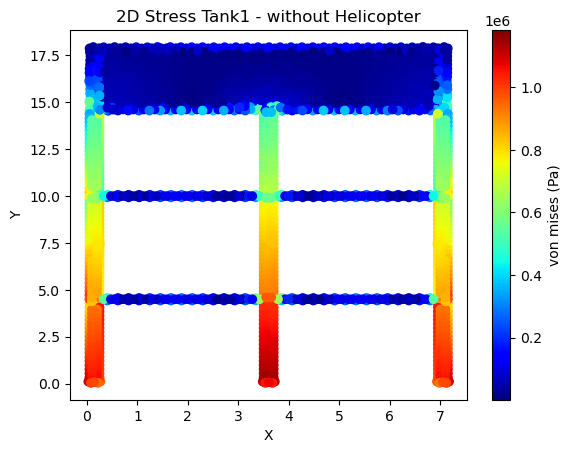

In [282]:
# Assuming von_m is already calculated from the `stress` vector
von_m = von_mises_stress_t1[0]

# Coordinates of the centroids
x = centroid_t1[0][0, :]
y = centroid_t1[0][1, :]

# Find the index of the maximum stress value
max_stress_index = np.argmax(von_m[0, :])
print("x coordinate:" , x[max_stress_index], "  y coordinate:", y[max_stress_index])
max_x = x[max_stress_index]
max_y = y[max_stress_index]
max_stress_value = von_m[0, max_stress_index]
print("Maximum Stress value:", max_stress_value, "(Pa)")

# Create a scatter plot of stress distribution
scatter = plt.scatter(x, y, c=von_m[0, :], cmap='jet')
plt.colorbar(scatter, label='von mises (Pa)')

# Highlight the point with the maximum stress
# plt.scatter(max_x, max_y, color='black', s=100, marker='x')
# plt.text(max_x, max_y, f'({max_x:.2f}, {max_y:.2f})', color='red', fontsize=10)

# Labels for axes
plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D Stress Tank1 - without Helicopter')

# Show the legend
# plt.legend()

# Show the plot
plt.show()

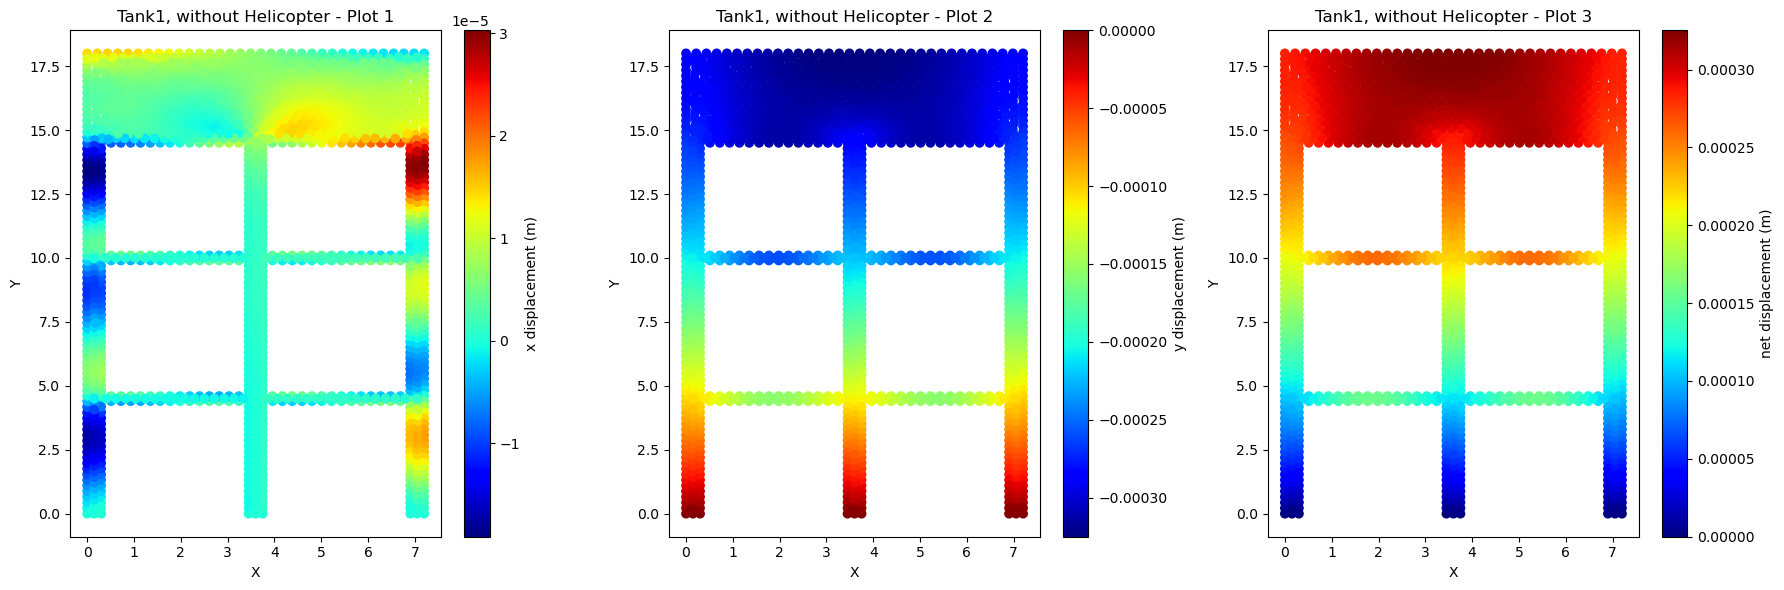

In [283]:
u_val = sol_t1_max_stress[0][::2]
v_val = sol_t1_max_stress[0][1::2]
net_val = np.sqrt(u_val**2 + v_val**2)
x = coordinates_t1[0][:,0]
y = coordinates_t1[0][:,1]

# Create a figure with 3 subplots side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Adjust figsize as needed for spacing

# First plot
scatter1 = axes[0].scatter(x, y, c=u_val, cmap='jet')
axes[0].set_title('Tank1, without Helicopter - Plot 1')
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')
fig.colorbar(scatter1, ax=axes[0], label='x displacement (m)')

# Second plot
scatter2 = axes[1].scatter(x, y, c=v_val, cmap='jet')
axes[1].set_title('Tank1, without Helicopter - Plot 2')
axes[1].set_xlabel('X')
axes[1].set_ylabel('Y')
fig.colorbar(scatter2, ax=axes[1], label='y displacement (m)')

# Third plot
scatter3 = axes[2].scatter(x, y, c=net_val, cmap='jet')
axes[2].set_title('Tank1, without Helicopter - Plot 3')
axes[2].set_xlabel('X')
axes[2].set_ylabel('Y')
fig.colorbar(scatter3, ax=axes[2], label='net displacement (m)')

# Adjust layout for spacing
plt.tight_layout()

# Show the combined figure
plt.show()


Tank1 with Helicopter

x coordinate: 3.671876301541046   y coordinate: 0.21170544019335946
Maximum Stress value: 1197502.6550468132 (Pa)


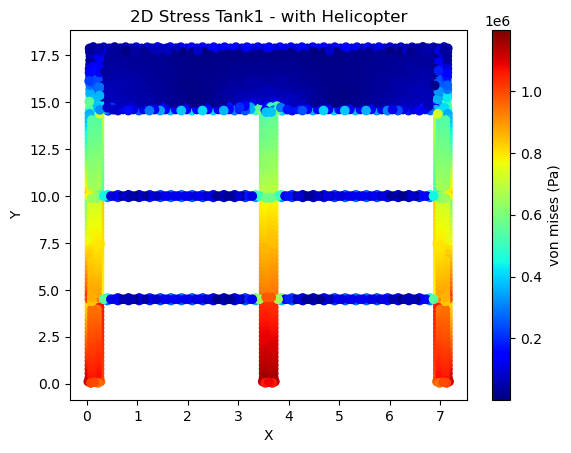

In [284]:
# Assuming von_m is already calculated from the `stress` vector
von_m = von_mises_stress_t1[1]

# Coordinates of the centroids
x = centroid_t1[1][0, :]
y = centroid_t1[1][1, :]

# Find the index of the maximum stress value
max_stress_index = np.argmax(von_m[0, :])
print("x coordinate:" , x[max_stress_index], "  y coordinate:", y[max_stress_index])
max_x = x[max_stress_index]
max_y = y[max_stress_index]
max_stress_value = von_m[0, max_stress_index]
print("Maximum Stress value:", max_stress_value, "(Pa)")

# Create a scatter plot of stress distribution
scatter = plt.scatter(x, y, c=von_m[0, :], cmap='jet')
plt.colorbar(scatter, label='von mises (Pa)')

# Highlight the point with the maximum stress
# plt.scatter(max_x, max_y, color='black', s=100, marker='x')
# plt.text(max_x, max_y, f'({max_x:.2f}, {max_y:.2f})', color='red', fontsize=10)

# Labels for axes
plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D Stress Tank1 - with Helicopter')

# Show the legend
# plt.legend()

# Show the plot
plt.show()

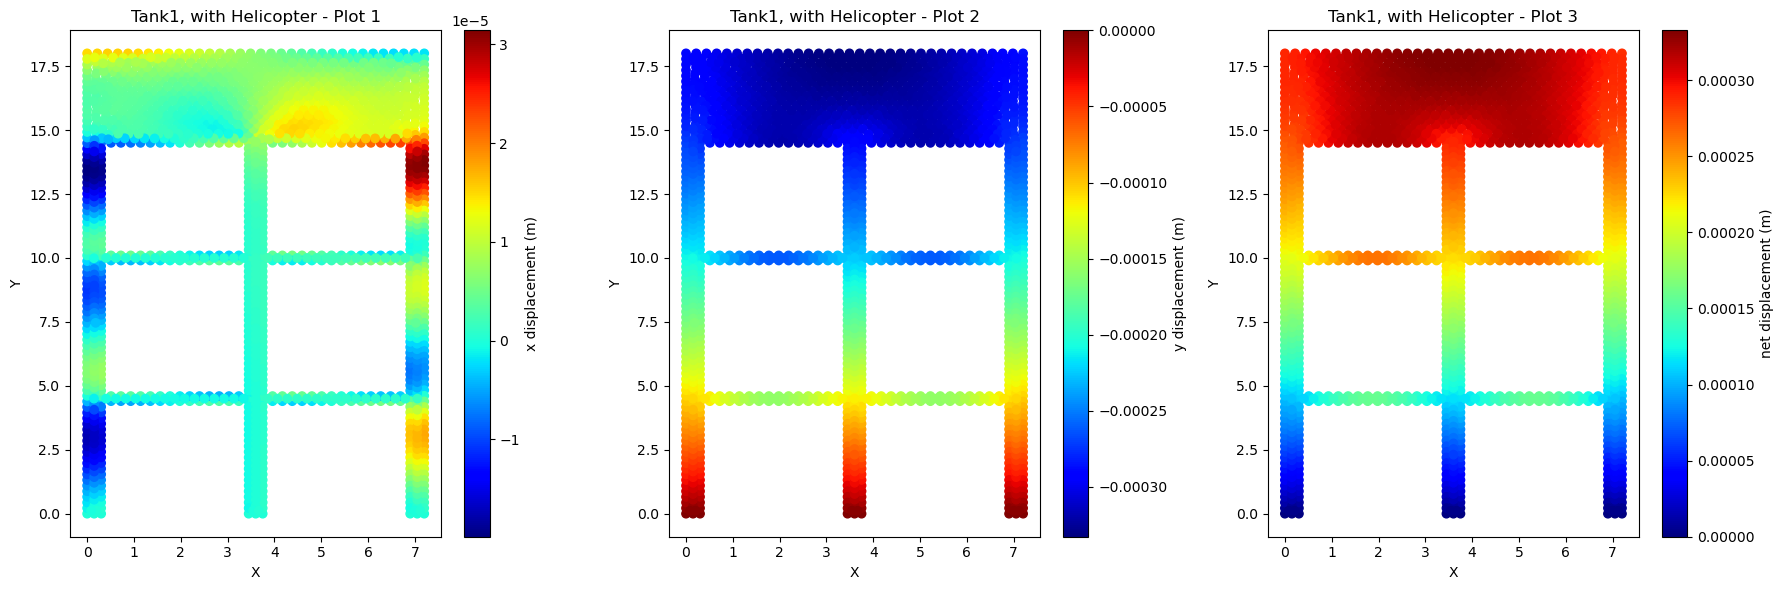

In [285]:
u_val = sol_t1_max_stress[1][::2]
v_val = sol_t1_max_stress[1][1::2]
net_val = np.sqrt(u_val**2 + v_val**2)
x = coordinates_t1[1][:,0]
y = coordinates_t1[1][:,1]

# Create a figure with 3 subplots side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Adjust figsize as needed for spacing

# First plot
scatter1 = axes[0].scatter(x, y, c=u_val, cmap='jet')
axes[0].set_title('Tank1, with Helicopter - Plot 1')
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')
fig.colorbar(scatter1, ax=axes[0], label='x displacement (m)')

# Second plot
scatter2 = axes[1].scatter(x, y, c=v_val, cmap='jet')
axes[1].set_title('Tank1, with Helicopter - Plot 2')
axes[1].set_xlabel('X')
axes[1].set_ylabel('Y')
fig.colorbar(scatter2, ax=axes[1], label='y displacement (m)')

# Third plot
scatter3 = axes[2].scatter(x, y, c=net_val, cmap='jet')
axes[2].set_title('Tank1, with Helicopter - Plot 3')
axes[2].set_xlabel('X')
axes[2].set_ylabel('Y')
fig.colorbar(scatter3, ax=axes[2], label='net displacement (m)')

# Adjust layout for spacing
plt.tight_layout()

# Show the combined figure
plt.show()


Tank2 without helicopter

x coordinate: 4.645780071594857   y coordinate: 0.34451643463936305
Maximum Stress value: 2007955.0153937642 (Pa)


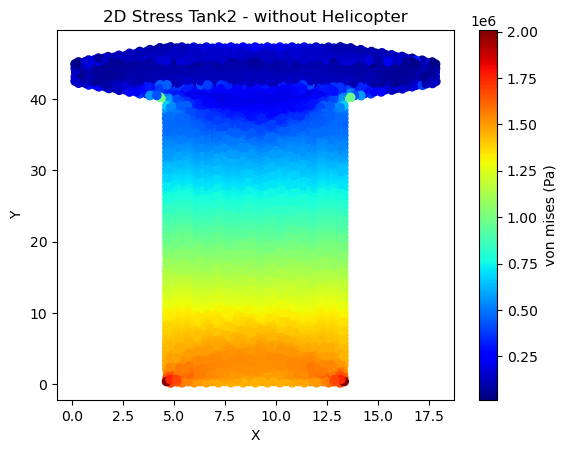

In [286]:
# Assuming von_m is already calculated from the `stress` vector
von_m = von_mises_stress_t2[0]

# Coordinates of the centroids
x = centroid_t2[0][0, :]
y = centroid_t2[0][1, :]

# Find the index of the maximum stress value
max_stress_index = np.argmax(von_m[0, :])
print("x coordinate:" , x[max_stress_index], "  y coordinate:", y[max_stress_index])
max_x = x[max_stress_index]
max_y = y[max_stress_index]
max_stress_value = von_m[0, max_stress_index]
print("Maximum Stress value:", max_stress_value, "(Pa)")

# Create a scatter plot of stress distribution
scatter = plt.scatter(x, y, c=von_m[0, :], cmap='jet')
plt.colorbar(scatter, label='von mises (Pa)')

# Highlight the point with the maximum stress
# plt.scatter(max_x, max_y, color='black', s=100, marker='x')
# plt.text(max_x, max_y, f'({max_x:.2f}, {max_y:.2f})', color='red', fontsize=10)

# Labels for axes
plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D Stress Tank2 - without Helicopter')

# Show the legend
# plt.legend()

# Show the plot
plt.show()

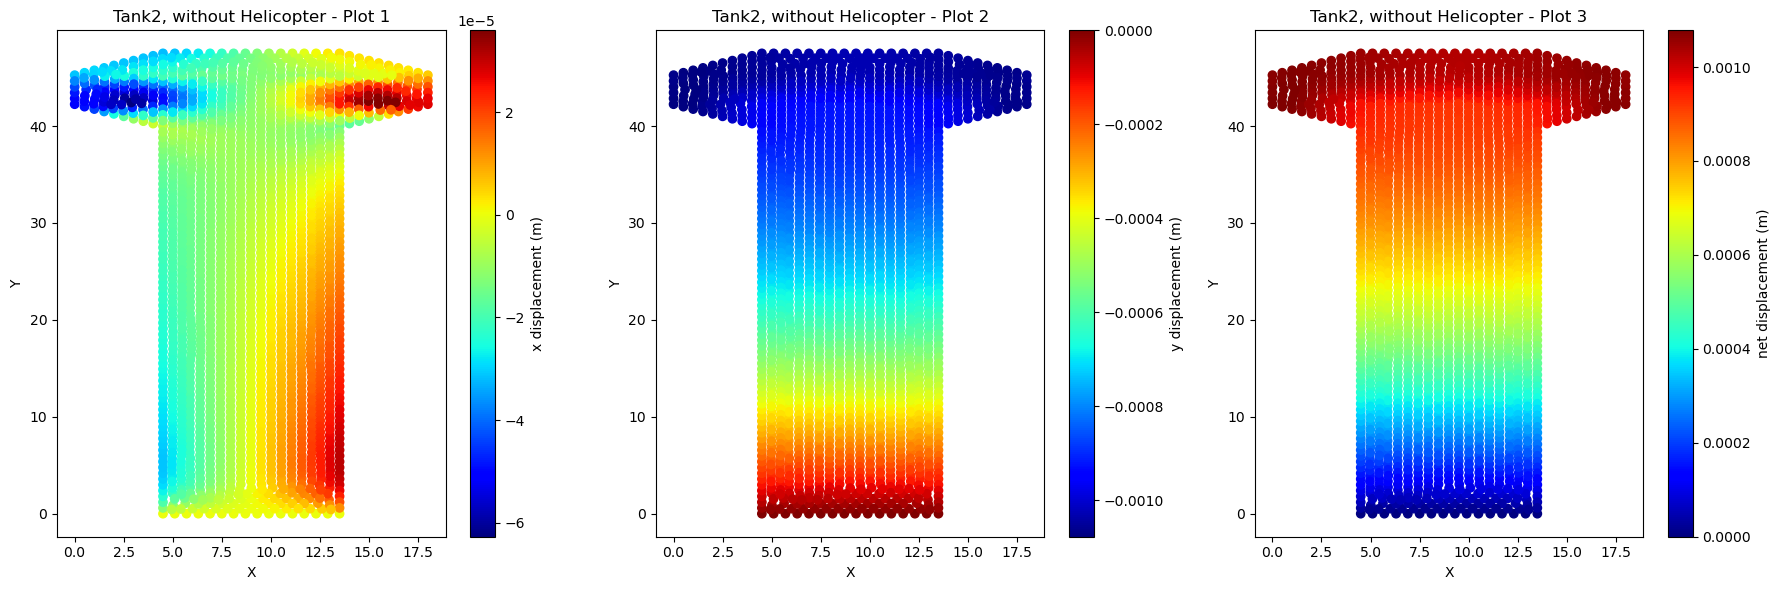

In [287]:
u_val = sol_t2_max_stress[0][::2]
v_val = sol_t2_max_stress[0][1::2]
net_val = np.sqrt(u_val**2 + v_val**2)
x = coordinates_t2[0][:,0]
y = coordinates_t2[0][:,1]

# Create a figure with 3 subplots side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Adjust figsize as needed for spacing

# First plot
scatter1 = axes[0].scatter(x, y, c=u_val, cmap='jet')
axes[0].set_title('Tank2, without Helicopter - Plot 1')
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')
fig.colorbar(scatter1, ax=axes[0], label='x displacement (m)')

# Second plot
scatter2 = axes[1].scatter(x, y, c=v_val, cmap='jet')
axes[1].set_title('Tank2, without Helicopter - Plot 2')
axes[1].set_xlabel('X')
axes[1].set_ylabel('Y')
fig.colorbar(scatter2, ax=axes[1], label='y displacement (m)')

# Third plot
scatter3 = axes[2].scatter(x, y, c=net_val, cmap='jet')
axes[2].set_title('Tank2, without Helicopter - Plot 3')
axes[2].set_xlabel('X')
axes[2].set_ylabel('Y')
fig.colorbar(scatter3, ax=axes[2], label='net displacement (m)')

# Adjust layout for spacing
plt.tight_layout()

# Show the combined figure
plt.show()


Tank2 with helicopter

x coordinate: 4.645780071594857   y coordinate: 0.34451643463936305
Maximum Stress value: 2009444.469589855 (Pa)


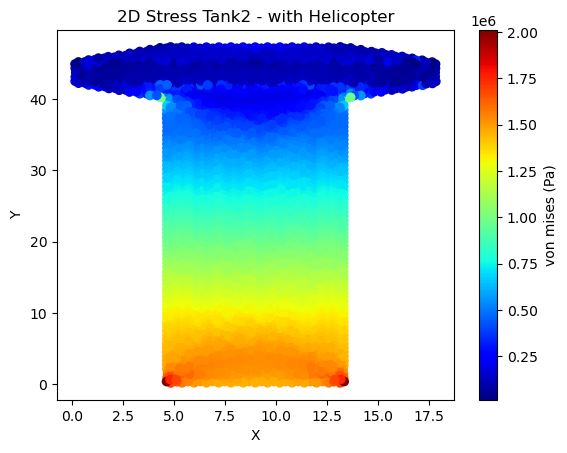

In [288]:
# Assuming von_m is already calculated from the `stress` vector
von_m = von_mises_stress_t2[1]

# Coordinates of the centroids
x = centroid_t2[1][0, :]
y = centroid_t2[1][1, :]

# Find the index of the maximum stress value
max_stress_index = np.argmax(von_m[0, :])
print("x coordinate:" , x[max_stress_index], "  y coordinate:", y[max_stress_index])
max_x = x[max_stress_index]
max_y = y[max_stress_index]
max_stress_value = von_m[0, max_stress_index]
print("Maximum Stress value:", max_stress_value, "(Pa)")

# Create a scatter plot of stress distribution
scatter = plt.scatter(x, y, c=von_m[0, :], cmap='jet')
plt.colorbar(scatter, label='von mises (Pa)')

# Highlight the point with the maximum stress
# plt.scatter(max_x, max_y, color='black', s=100, marker='x')
# plt.text(max_x, max_y, f'({max_x:.2f}, {max_y:.2f})', color='red', fontsize=10)

# Labels for axes
plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D Stress Tank2 - with Helicopter')

# Show the legend
# plt.legend()

# Show the plot
plt.show()

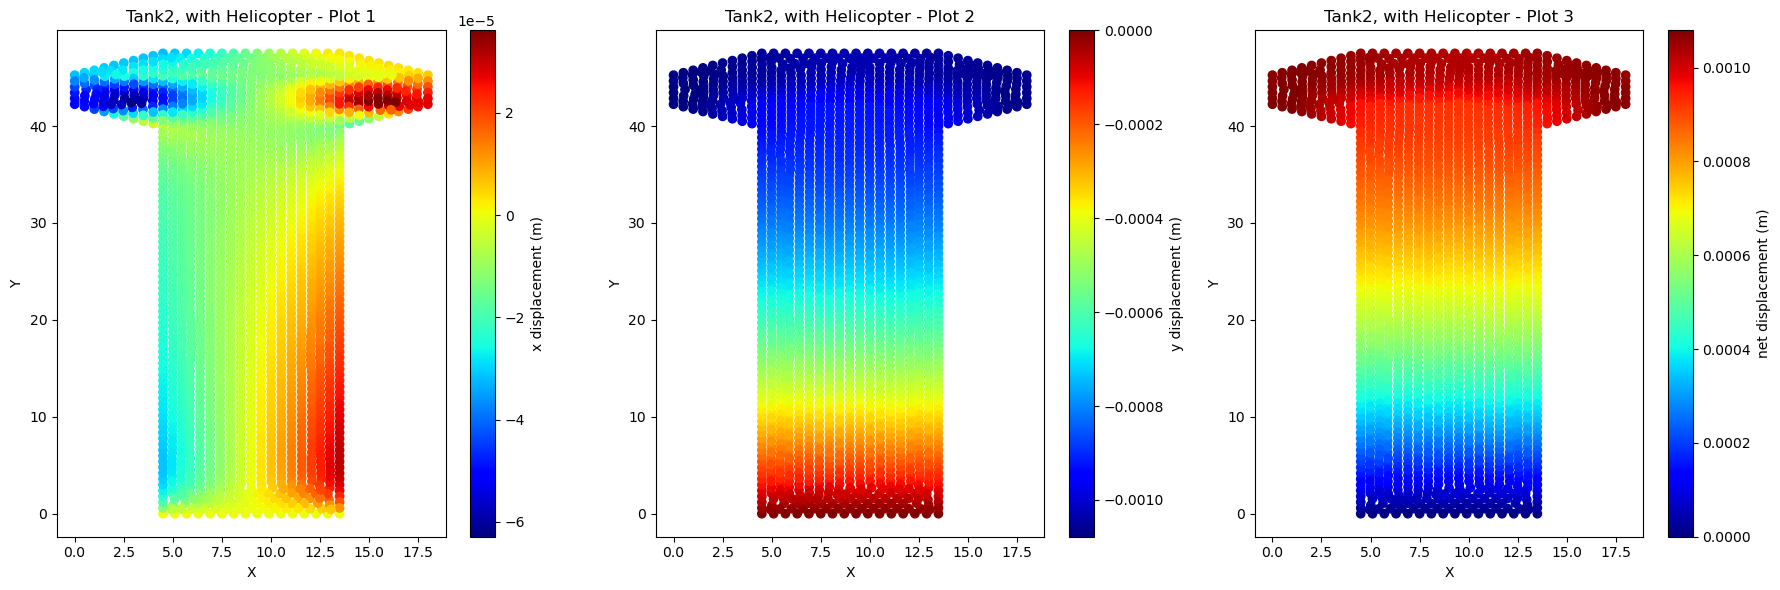

In [289]:
u_val = sol_t2_max_stress[1][::2]
v_val = sol_t2_max_stress[1][1::2]
net_val = np.sqrt(u_val**2 + v_val**2)
x = coordinates_t2[1][:,0]
y = coordinates_t2[1][:,1]

# Create a figure with 3 subplots side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Adjust figsize as needed for spacing

# First plot
scatter1 = axes[0].scatter(x, y, c=u_val, cmap='jet')
axes[0].set_title('Tank2, with Helicopter - Plot 1')
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')
fig.colorbar(scatter1, ax=axes[0], label='x displacement (m)')

# Second plot
scatter2 = axes[1].scatter(x, y, c=v_val, cmap='jet')
axes[1].set_title('Tank2, with Helicopter - Plot 2')
axes[1].set_xlabel('X')
axes[1].set_ylabel('Y')
fig.colorbar(scatter2, ax=axes[1], label='y displacement (m)')

# Third plot
scatter3 = axes[2].scatter(x, y, c=net_val, cmap='jet')
axes[2].set_title('Tank2, with Helicopter - Plot 3')
axes[2].set_xlabel('X')
axes[2].set_ylabel('Y')
fig.colorbar(scatter3, ax=axes[2], label='net displacement (m)')

# Adjust layout for spacing
plt.tight_layout()

# Show the combined figure
plt.show()


**Plotting First 2 Mode shape of Tanks**

In [292]:
coords_t1 = []
for i in range(len(tank1_files)):
    
    gmsh.initialize()

    # gmsh.open('IITM_Map_final')
    gmsh.open(tank1_files[i])

    # Unpack the three return values (nodeTags, coordinates, parametricCoordinates)
    nodeTags, coordinates, _ = gmsh.model.mesh.getNodes(-1, -1)

    # Total number of nodes is the length of nodeTags
    total_nodes = len(nodeTags)
    coordinates = coordinates.reshape((-1, 3))

    sorted_indices = np.argsort(nodeTags)
    sorted_coordinates = coordinates[sorted_indices]
    
    coords_t1.append(sorted_coordinates)
    gmsh.finalize()

In [293]:
coords_t2 = []
for i in range(len(tank2_files)):
    gmsh.initialize()

    # gmsh.open('IITM_Map_final')
    gmsh.open(tank2_files[i])

    # Unpack the three return values (nodeTags, coordinates, parametricCoordinates)
    nodeTags, coordinates, _ = gmsh.model.mesh.getNodes(-1, -1)

    # Total number of nodes is the length of nodeTags
    total_nodes = len(nodeTags)
    coordinates = coordinates.reshape((-1, 3))

    sorted_indices = np.argsort(nodeTags)
    sorted_coordinates = coordinates[sorted_indices]
    
    coords_t2.append(sorted_coordinates)
    gmsh.finalize()

In [311]:
eigenvectors_t1[0].shape

(2930, 2928)

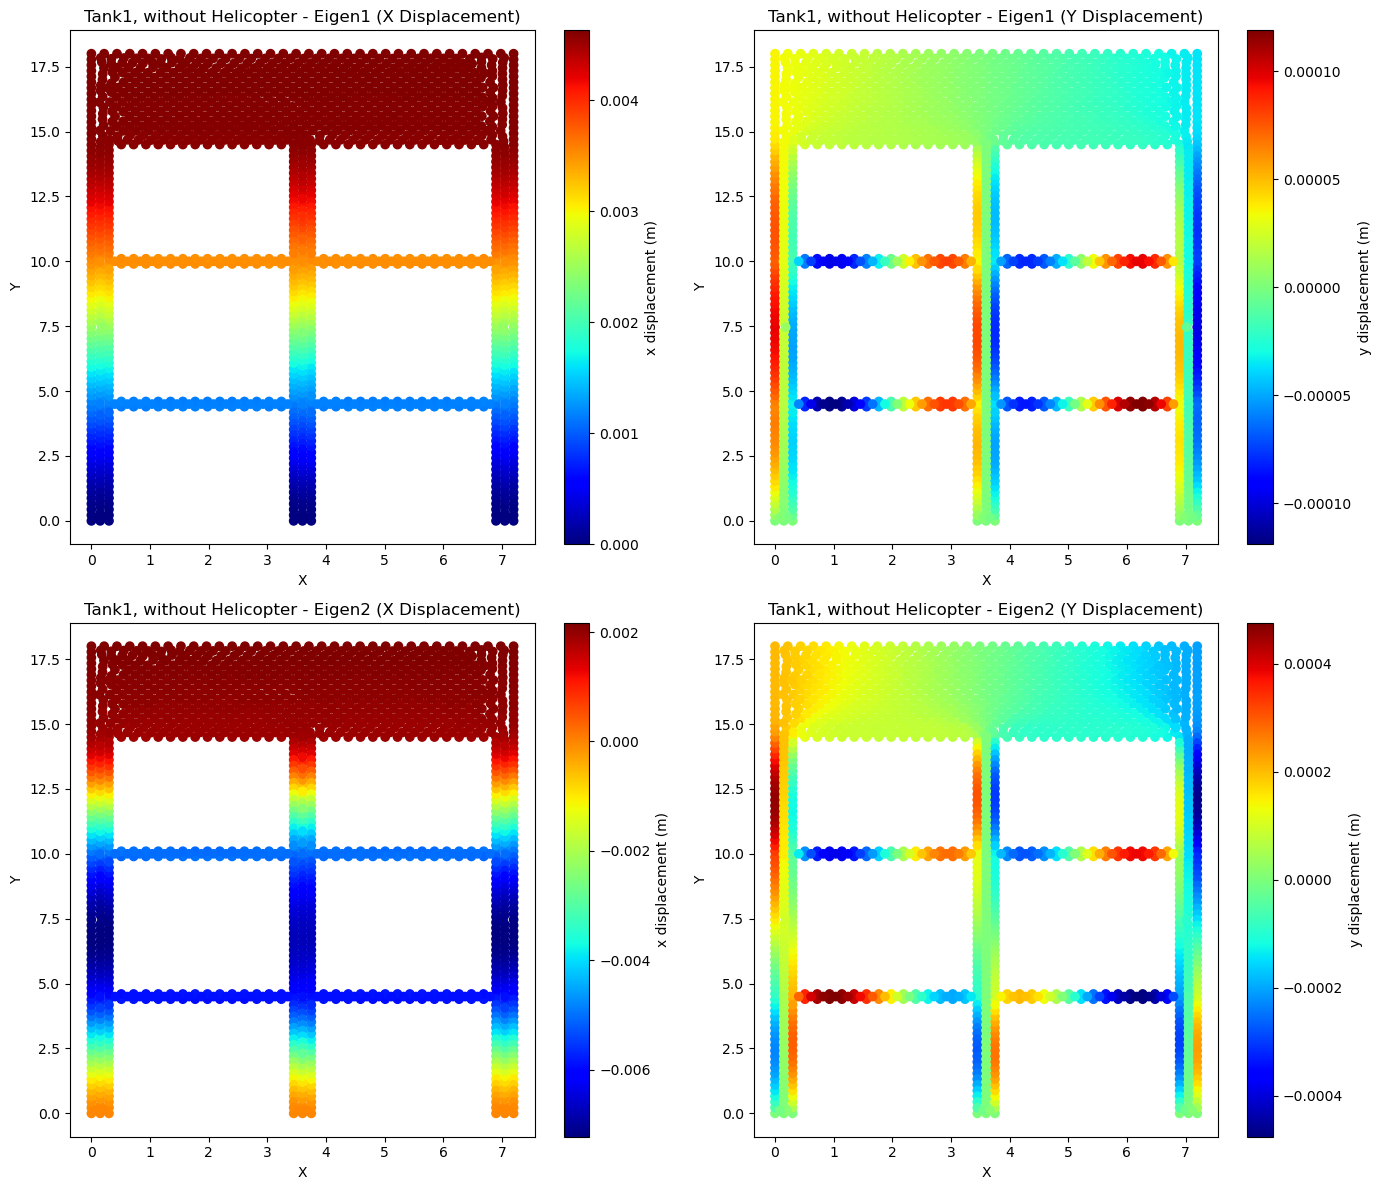

In [319]:
# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 12))  # Adjust figsize as needed

# Loop to plot x and y displacements for the first two eigenvectors
for i in range(2):
    n = coords_t1[0].shape[0]
    C_val = np.zeros((2*n, 1))
    C_val[uk_i_t1[0], 0] = eigenvectors_t1[0][:, i].real
    u_val = C_val[::2]
    v_val = C_val[1::2]

    net_val = np.sqrt(u_val**2 + v_val**2)
    x = coords_t1[0][:, 0]
    y = coords_t1[0][:, 1]

    # Plot x displacement for the i-th eigenvector
    scatter_x = axes[i, 0].scatter(x, y, c=u_val, cmap='jet')
    axes[i, 0].set_title(f'Tank1, without Helicopter - Eigen{i+1} (X Displacement)')
    axes[i, 0].set_xlabel('X')
    axes[i, 0].set_ylabel('Y')
    fig.colorbar(scatter_x, ax=axes[i, 0], label='x displacement (m)')

    # Plot y displacement for the i-th eigenvector
    scatter_y = axes[i, 1].scatter(x, y, c=v_val, cmap='jet')
    axes[i, 1].set_title(f'Tank1, without Helicopter - Eigen{i+1} (Y Displacement)')
    axes[i, 1].set_xlabel('X')
    axes[i, 1].set_ylabel('Y')
    fig.colorbar(scatter_y, ax=axes[i, 1], label='y displacement (m)')

# Adjust layout for spacing
plt.tight_layout()

# Show the combined figure
plt.show()

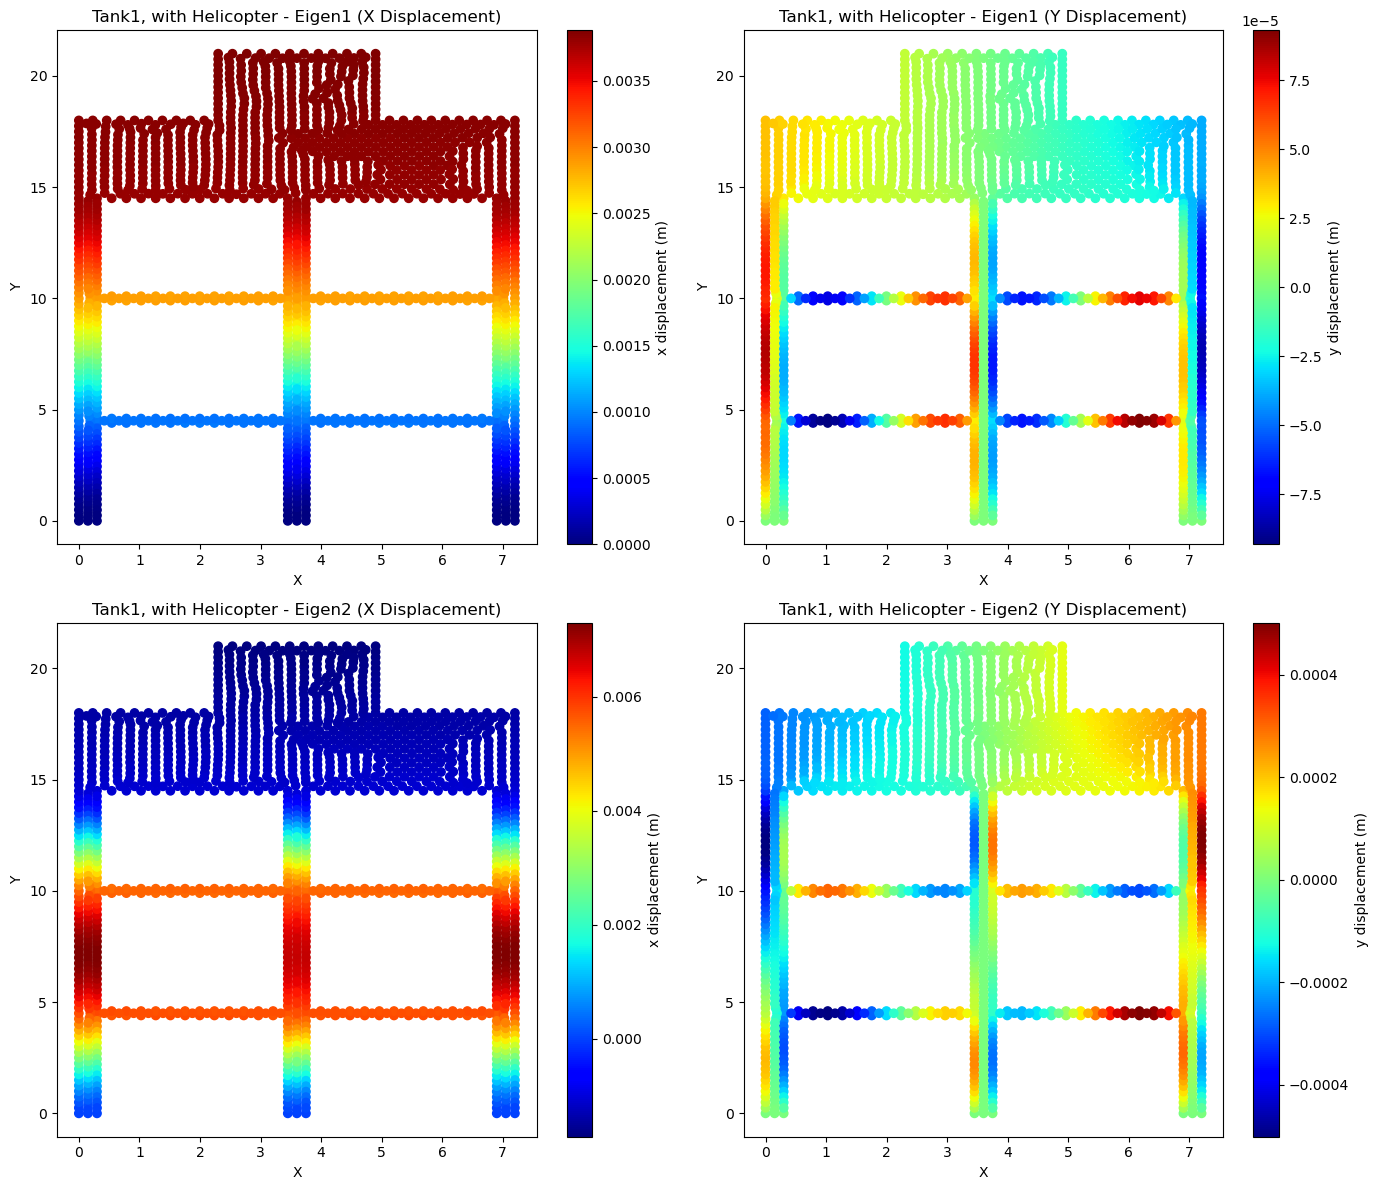

In [320]:
# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 12))  # Adjust figsize as needed

# Loop to plot x and y displacements for the first two eigenvectors
for i in range(2):
    n = coords_t1[1].shape[0]
    C_val = np.zeros((2*n, 1))
    C_val[uk_i_t1[1], 0] = eigenvectors_t1[1][:, i].real
    u_val = C_val[::2]
    v_val = C_val[1::2]

    net_val = np.sqrt(u_val**2 + v_val**2)
    x = coords_t1[1][:, 0]
    y = coords_t1[1][:, 1]

    # Plot x displacement for the i-th eigenvector
    scatter_x = axes[i, 0].scatter(x, y, c=u_val, cmap='jet')
    axes[i, 0].set_title(f'Tank1, with Helicopter - Eigen{i+1} (X Displacement)')
    axes[i, 0].set_xlabel('X')
    axes[i, 0].set_ylabel('Y')
    fig.colorbar(scatter_x, ax=axes[i, 0], label='x displacement (m)')

    # Plot y displacement for the i-th eigenvector
    scatter_y = axes[i, 1].scatter(x, y, c=v_val, cmap='jet')
    axes[i, 1].set_title(f'Tank1, with Helicopter - Eigen{i+1} (Y Displacement)')
    axes[i, 1].set_xlabel('X')
    axes[i, 1].set_ylabel('Y')
    fig.colorbar(scatter_y, ax=axes[i, 1], label='y displacement (m)')

# Adjust layout for spacing
plt.tight_layout()

# Show the combined figure
plt.show()

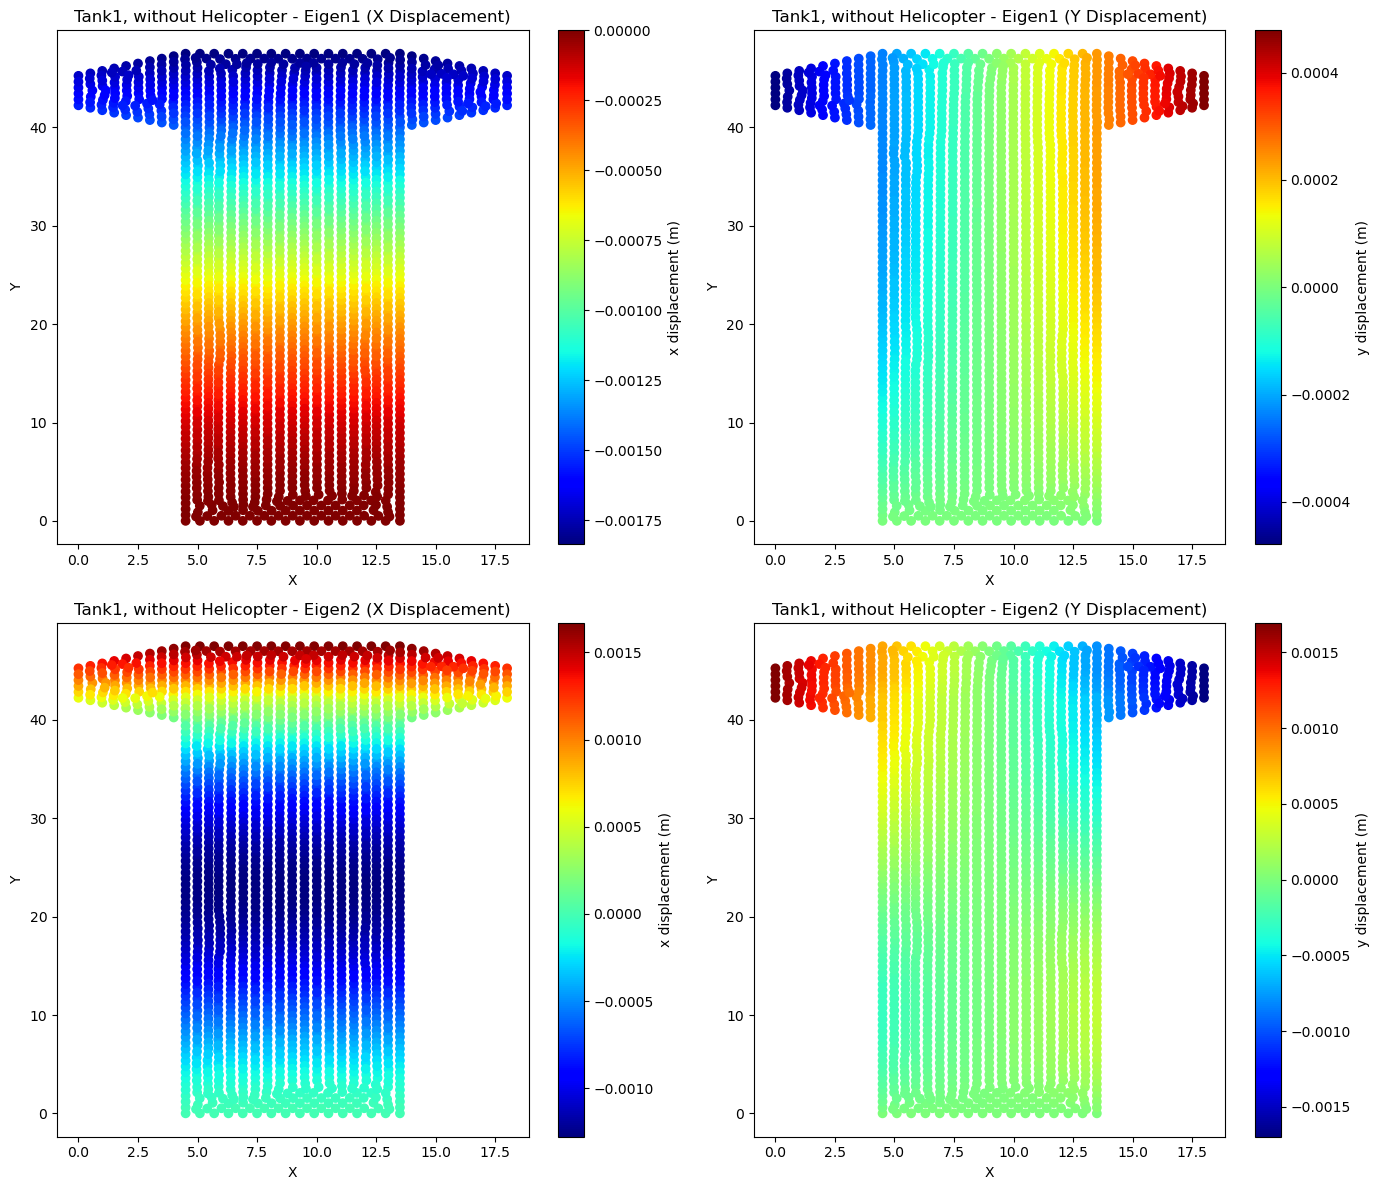

In [321]:
# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 12))  # Adjust figsize as needed

# Loop to plot x and y displacements for the first two eigenvectors
for i in range(2):
    n = coords_t2[0].shape[0]
    C_val = np.zeros((2*n, 1))
    C_val[uk_i_t2[0], 0] = eigenvectors_t2[0][:, i].real
    u_val = C_val[::2]
    v_val = C_val[1::2]

    net_val = np.sqrt(u_val**2 + v_val**2)
    x = coords_t2[0][:, 0]
    y = coords_t2[0][:, 1]

    # Plot x displacement for the i-th eigenvector
    scatter_x = axes[i, 0].scatter(x, y, c=u_val, cmap='jet')
    axes[i, 0].set_title(f'Tank1, without Helicopter - Eigen{i+1} (X Displacement)')
    axes[i, 0].set_xlabel('X')
    axes[i, 0].set_ylabel('Y')
    fig.colorbar(scatter_x, ax=axes[i, 0], label='x displacement (m)')

    # Plot y displacement for the i-th eigenvector
    scatter_y = axes[i, 1].scatter(x, y, c=v_val, cmap='jet')
    axes[i, 1].set_title(f'Tank1, without Helicopter - Eigen{i+1} (Y Displacement)')
    axes[i, 1].set_xlabel('X')
    axes[i, 1].set_ylabel('Y')
    fig.colorbar(scatter_y, ax=axes[i, 1], label='y displacement (m)')

# Adjust layout for spacing
plt.tight_layout()

# Show the combined figure
plt.show()

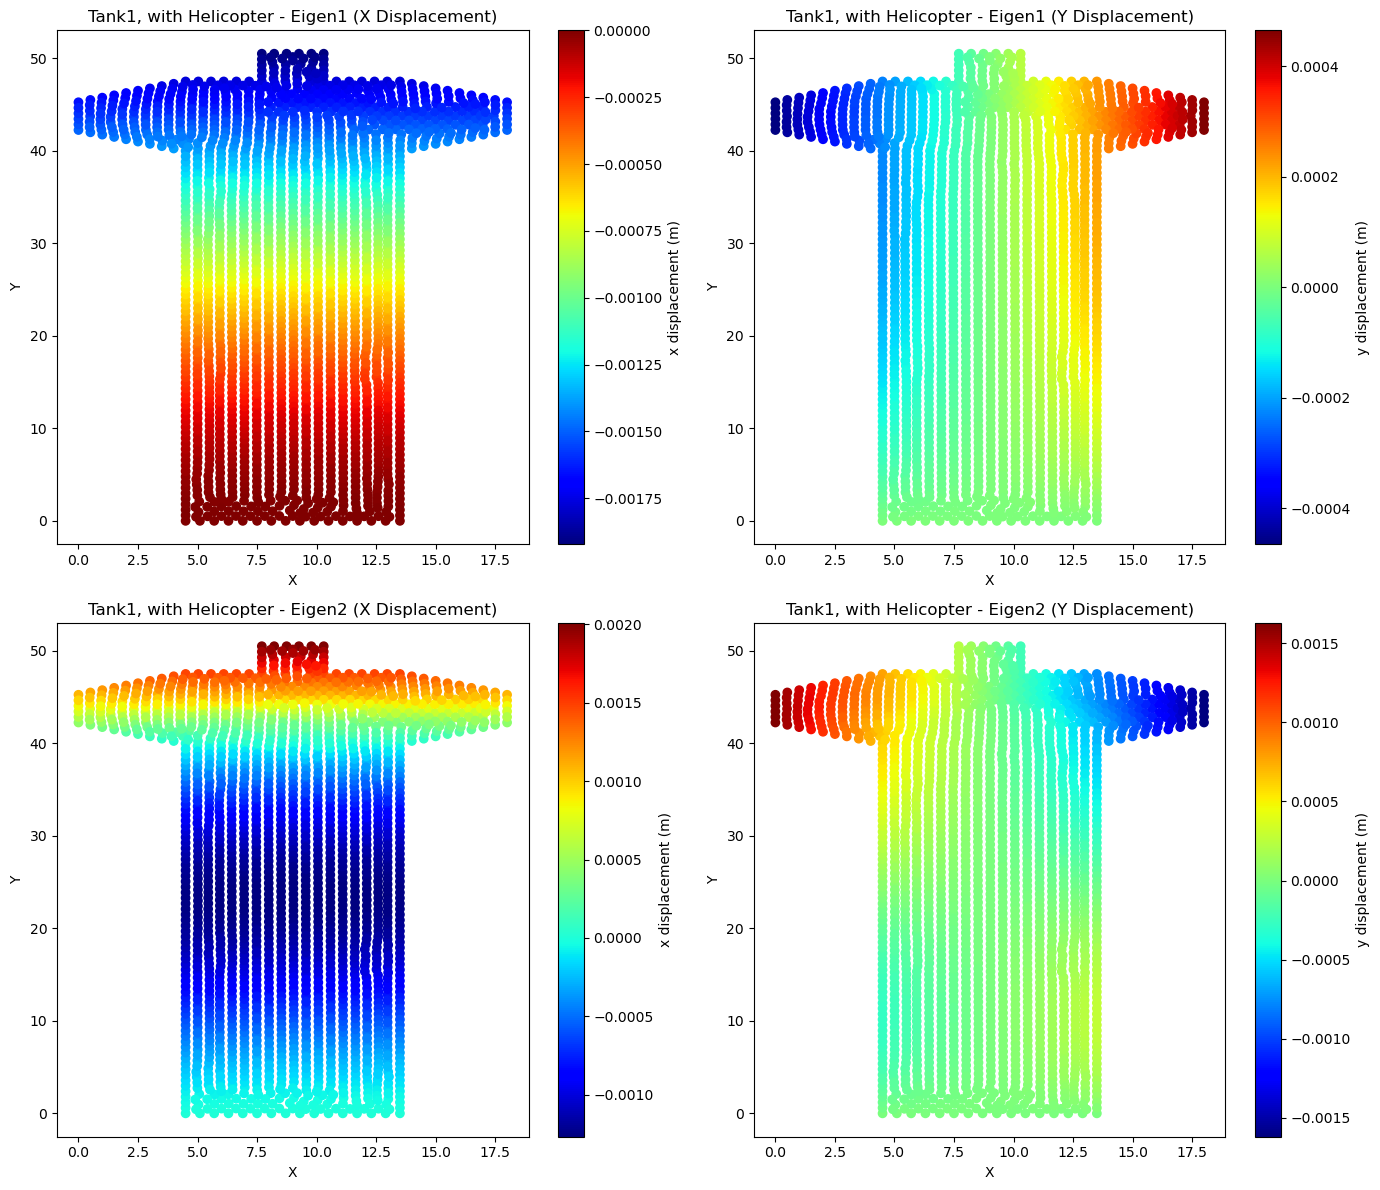

In [322]:
# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 12))  # Adjust figsize as needed

# Loop to plot x and y displacements for the first two eigenvectors
for i in range(2):
    n = coords_t2[1].shape[0]
    C_val = np.zeros((2*n, 1))
    C_val[uk_i_t2[1], 0] = eigenvectors_t2[1][:, i].real
    u_val = C_val[::2]
    v_val = C_val[1::2]

    net_val = np.sqrt(u_val**2 + v_val**2)
    x = coords_t2[1][:, 0]
    y = coords_t2[1][:, 1]

    # Plot x displacement for the i-th eigenvector
    scatter_x = axes[i, 0].scatter(x, y, c=u_val, cmap='jet')
    axes[i, 0].set_title(f'Tank1, with Helicopter - Eigen{i+1} (X Displacement)')
    axes[i, 0].set_xlabel('X')
    axes[i, 0].set_ylabel('Y')
    fig.colorbar(scatter_x, ax=axes[i, 0], label='x displacement (m)')

    # Plot y displacement for the i-th eigenvector
    scatter_y = axes[i, 1].scatter(x, y, c=v_val, cmap='jet')
    axes[i, 1].set_title(f'Tank1, with Helicopter - Eigen{i+1} (Y Displacement)')
    axes[i, 1].set_xlabel('X')
    axes[i, 1].set_ylabel('Y')
    fig.colorbar(scatter_y, ax=axes[i, 1], label='y displacement (m)')

# Adjust layout for spacing
plt.tight_layout()

# Show the combined figure
plt.show()

In [313]:
uk_i_t1[0]

array([   2,    3,    4, ..., 2945, 2946, 2947])

Transient Analysis

In [111]:
M = construct_mass(total_nodes, node_tags, triangle, "tank1")

In [112]:
M.shape

(1730, 1730)

In [113]:
M

array([[17.8       ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , 17.8       ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        , 26.35382907, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., 24.05865503,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        28.69730534,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , 28.69730534]])

In [114]:
K_sub, M_sub, C_trans, unkown_indices = static_solution("submatrix", total_nodes, ground, K, f, M)

In [115]:
eigenvalues, eigenvectors = cal_eigen(M_sub, K_sub)

In [116]:
eigenvalues

array([1.25022689e+02+0.j, 3.35516841e+03+0.j, 1.33950488e+04+0.j, ...,
       1.94534395e+09+0.j, 1.94681112e+09+0.j, 1.94650419e+09+0.j])

In [117]:
eigenvalues[0:9]

array([   125.02268887+0.j,   3355.16840907+0.j,  13395.04880704+0.j,
        37478.51915564+0.j,  47180.93831424+0.j,  49231.57378261+0.j,
        64520.17829721+0.j,  90178.19837193+0.j, 123950.82126691+0.j])

In [118]:
eigenvectors[:,0].shape

(1718,)

In [119]:
C_trans[unkown_indices,0] = eigenvectors[:,0].real

In [120]:
np.max(eigenvectors[:,0])

(0.00011799358628507983+0j)

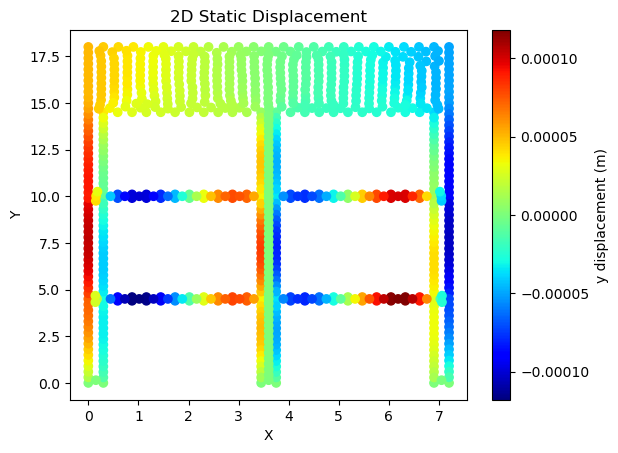

In [121]:
# Create a scatter plot
x = sorted_coordinates[:, 0]
y = sorted_coordinates[:, 1]
scatter = plt.scatter(x, y, c=-1*C_trans[1::2], cmap='jet')  # 'c' assigns color based on temperature

# Add a color bar to represent the temperature scale
plt.colorbar(scatter, label='y displacement (m)')  # Optional label for the color bar

# Labels for axes
plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D Static Displacement')
# Show the plot
plt.show()

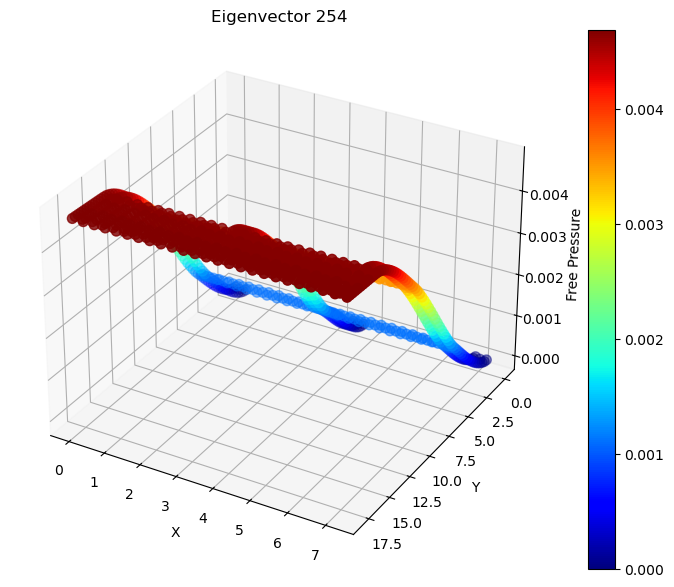

In [91]:
x = sorted_coordinates[:, 0]
y = sorted_coordinates[:, 1]
temperature = C_trans[::2]

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Eigenvector 254')

# Add a 3D scatter plot of the original data points
scatter = ax.scatter(x, y, temperature, c=temperature, cmap='jet', s=50)  # Scatter points

# Add a color bar
fig.colorbar(scatter, ax=ax)

# Labels for axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Free Pressure')

# Invert the y-axis if needed
ax.invert_yaxis()

# Show the plot
plt.show()